<a href="https://colab.research.google.com/github/Celinekimm/COVID-19-Coronavirus-Complete-Dataset/blob/main/Covid_19_S_Korea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
symptoms={'symptom':['Fever',
        'Dry cough',
        'Fatigue',
        'Sputum production',
        'Shortness of breath',
        'Muscle pain',
        'Sore throat',
        'Headache',
        'Chills',
        'Nausea or vomiting',
        'Nasal congestion',
        'Diarrhoea',
        'Haemoptysis',
        'Conjunctival congestion'],'percentage':[87.9,67.7,38.1,33.4,18.6,14.8,13.9,13.6,11.4,5.0,4.8,3.7,0.9,0.8]}

symptoms=pd.DataFrame(data=symptoms,index=range(14))
symptoms

symptom  percentage
0                     Fever        87.9
1                 Dry cough        67.7
2                   Fatigue        38.1
3         Sputum production        33.4
4       Shortness of breath        18.6
5               Muscle pain        14.8
6               Sore throat        13.9
7                  Headache        13.6
8                    Chills        11.4
9        Nausea or vomiting         5.0
10         Nasal congestion         4.8
11                Diarrhoea         3.7
12              Haemoptysis         0.9
13  Conjunctival congestion         0.8

In [3]:
fig = px.bar(symptoms[['symptom', 'percentage']].sort_values('percentage', ascending=False), 
             y="percentage", x="symptom", color='symptom', 
             log_y=True, template='ggplot2', title='Symptom of  Coronavirus')
fig.show()

<Figure size 720x432 with 0 Axes>

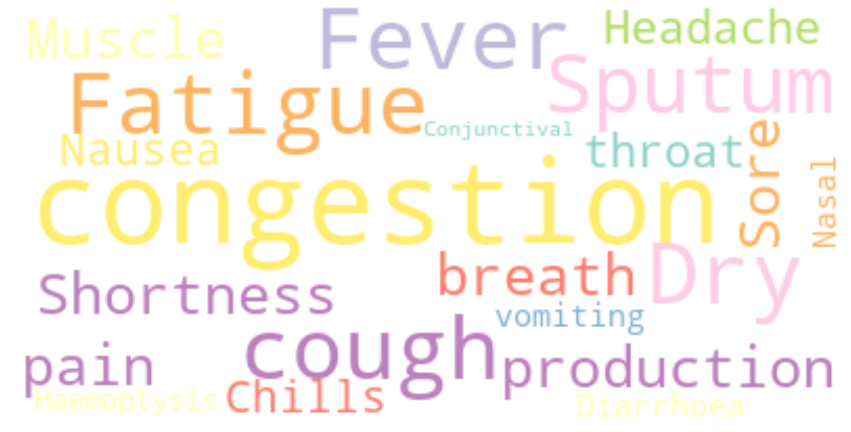

In [4]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in symptoms.symptom)
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="white").generate(text)
plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [9]:
# Importing data: PopulationDistribution
pop_dist = pd.read_csv('PopulationDistribution.csv')
pop_dist = pop_dist.iloc[:, np.r_[0, 1, 3:12, 14:15, 27]]
pop_dist.columns = ['location', 'total', '0s', '10s', '20s', '30s', '40s', '50s',
                   '60s', '70s', '80s', 'male_total', 'female_total']
pop_dist.head()

location       total  ...  male_total female_total
0     전국  (0000000000)  51,843,195  ...  25,858,743   25,984,452
1  서울특별시  (1100000000)   9,733,655  ...   4,742,217    4,991,438
2  부산광역시  (2600000000)   3,409,932  ...   1,672,252    1,737,680
3  대구광역시  (2700000000)   2,433,568  ...   1,202,273    1,231,295
4  인천광역시  (2800000000)   2,952,689  ...   1,479,839    1,472,850

[5 rows x 13 columns]

In [10]:
# Tag value on bars
def show_values_on_bars(axs, h_v="v", space=0.4, modh=0, modv=0):
    def _show_on_single_plot(ax):
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(modv)
                value = int(p.get_height())
                ax.text(_x, _y, value, ha='center') 
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - float(modh)
                value = int(p.get_width())
                ax.text(_x, _y, value, ha='left')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

*** By Gender ***

In [12]:
# Importing data: Gender
gender = pd.read_csv('TimeGender.csv')
gender.head(2)

date  time     sex  confirmed  deceased
0  2020-03-02     0    male       1591        13
1  2020-03-02     0  female       2621         9

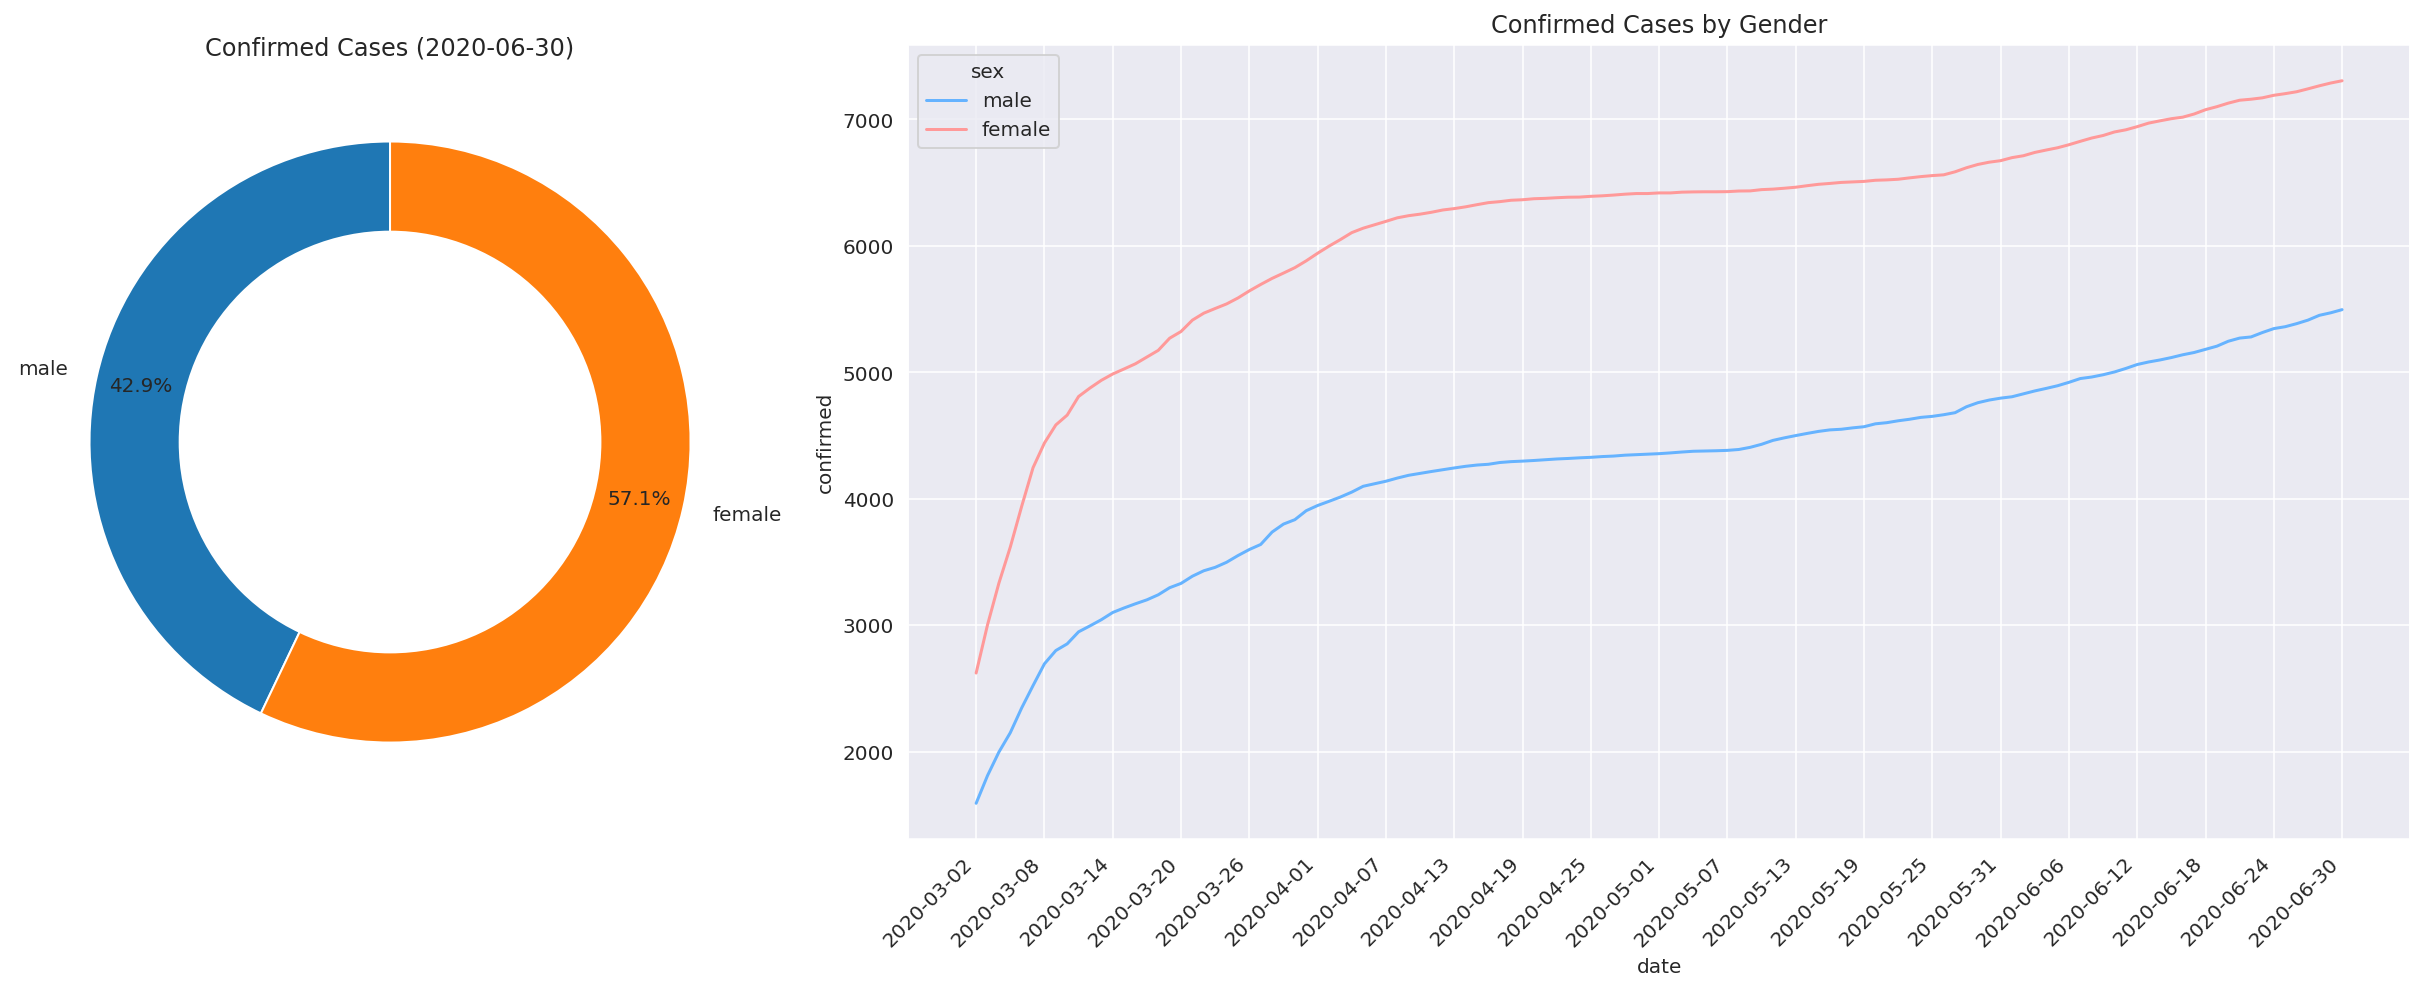

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7), gridspec_kw={'width_ratios': [1, 2]})
sns.set_palette(['#66b3ff','#ff9999'])

# Donut plot of confirmed cases by gender
ax1.title.set_text('Confirmed Cases ({0})'.format(gender.iloc[-1, 0]))
ax1.pie(gender.confirmed[-2:], labels=['male', 'female'], autopct='%.1f%%',
        startangle=90, pctdistance=0.85)
ax1.add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# Change in time of confirmed cases
ax2.title.set_text('Confirmed Cases by Gender')
sns.lineplot(data=gender, x='date', y='confirmed', hue='sex', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

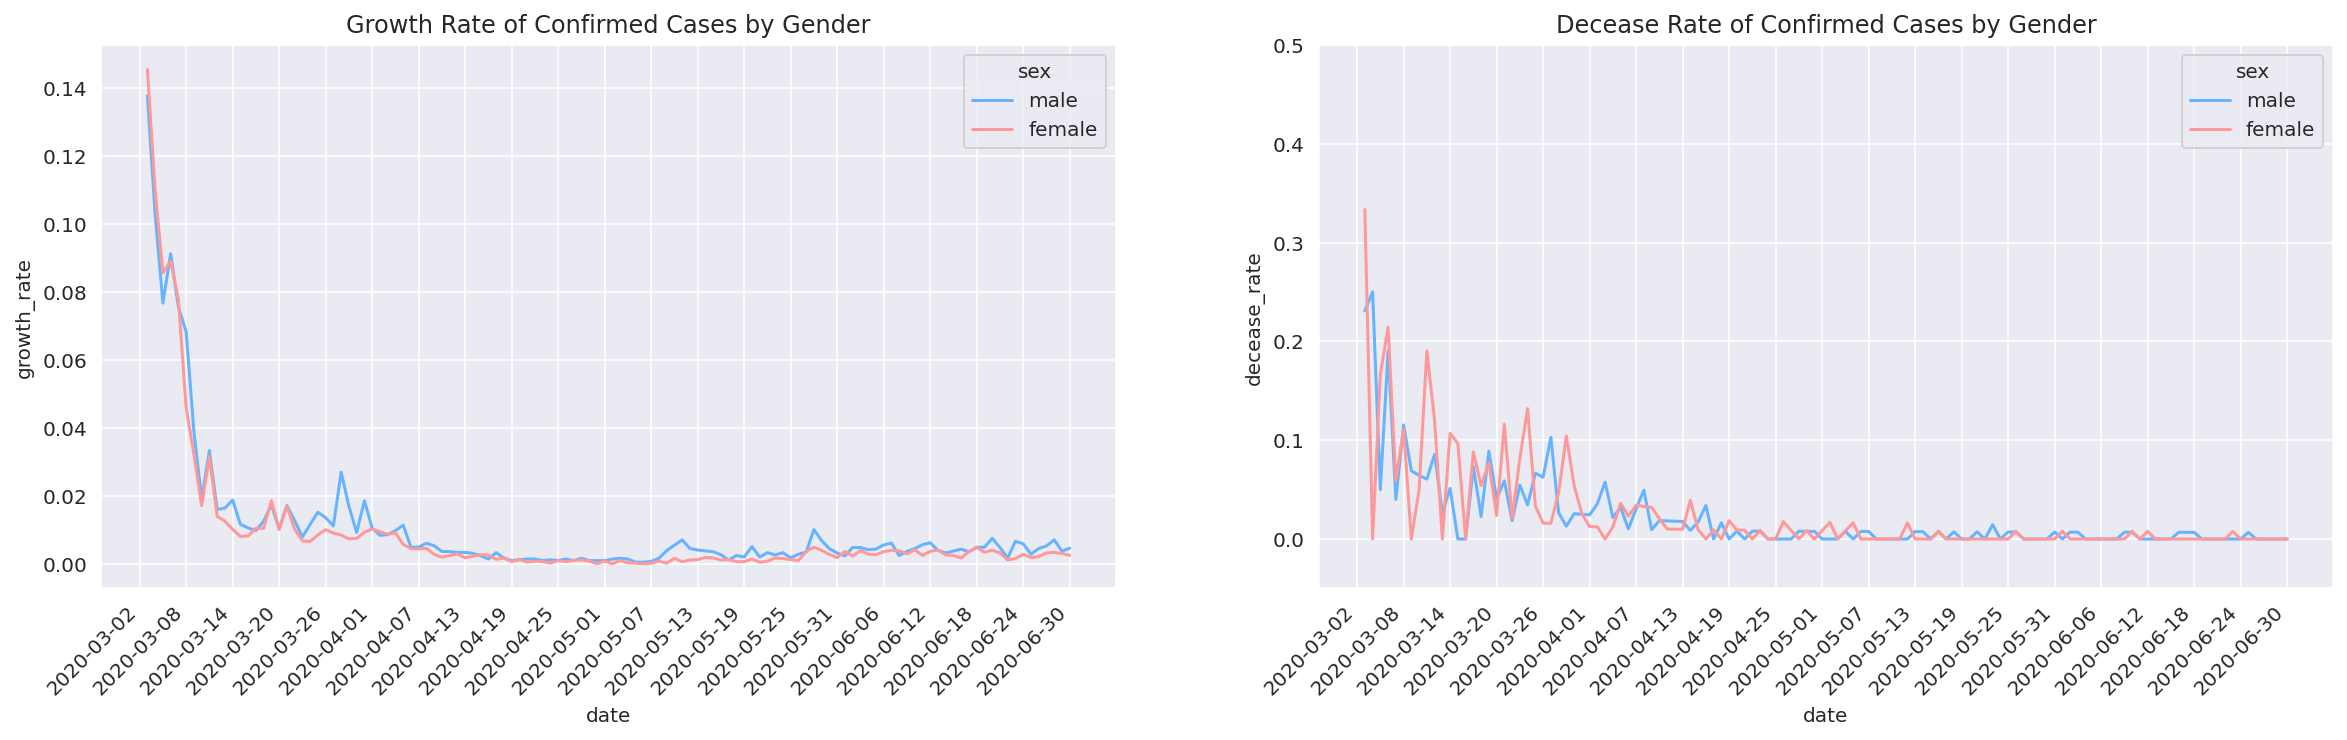

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases (Index - male: even, female: odd)
ax1.title.set_text('Growth Rate of Confirmed Cases by Gender')
gender['growth_rate'] = gender.groupby('sex')[['confirmed']].pct_change()
sns.lineplot(data=gender, x='date', y='growth_rate', hue='sex', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Gender')
# Limiting y axis range to reduce fluctuations in graph
ax2.set(ylim=(-0.05, 0.5))
gender['decease_rate'] = gender.groupby('sex')[['deceased']].pct_change()
sns.lineplot(data=gender, x='date', y='decease_rate', hue='sex', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.xticks(rotation=45, ha='right')

plt.show()

**Analysis & Conclusion**

More females are infected than males.
The growth rate of confirmed cases is similar regardless of genders.
Both genders show a similar trend of decease rate.
Gender isn't a significant factor that influences the infection rate. (No correlation)
The reason why more females were infected than men might be due to geological reasons or different lifestyles. 

*** By Age ***

In [17]:
# Importing data: Age
age = pd.read_csv('TimeAge.csv')
print('Unique items: {0}'.format(len(age['age'].unique())))
age.head(9)

Unique items: 9


date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         0
1  2020-03-02     0  10s        169         0
2  2020-03-02     0  20s       1235         0
3  2020-03-02     0  30s        506         1
4  2020-03-02     0  40s        633         1
5  2020-03-02     0  50s        834         5
6  2020-03-02     0  60s        530         6
7  2020-03-02     0  70s        192         6
8  2020-03-02     0  80s         81         3

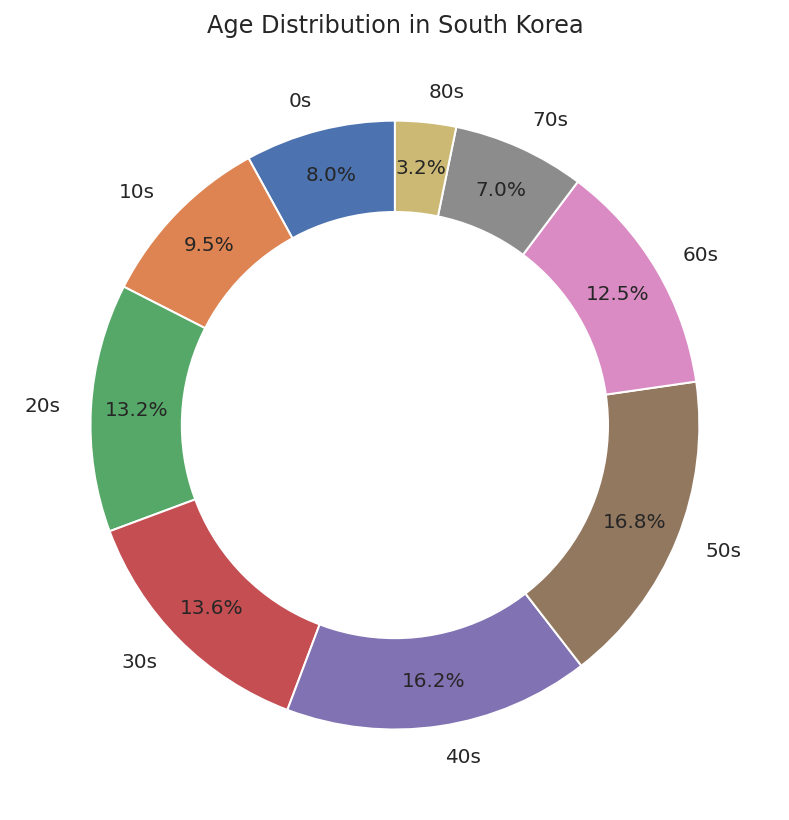

In [18]:
sns.set_palette('deep')
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')

# Population distribution by age
plt.figure(figsize=(7, 7))
plt.title('Age Distribution in South Korea')
plt.pie(pop_dist_age, labels=pop_dist_age.index, 
        autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))
plt.show()

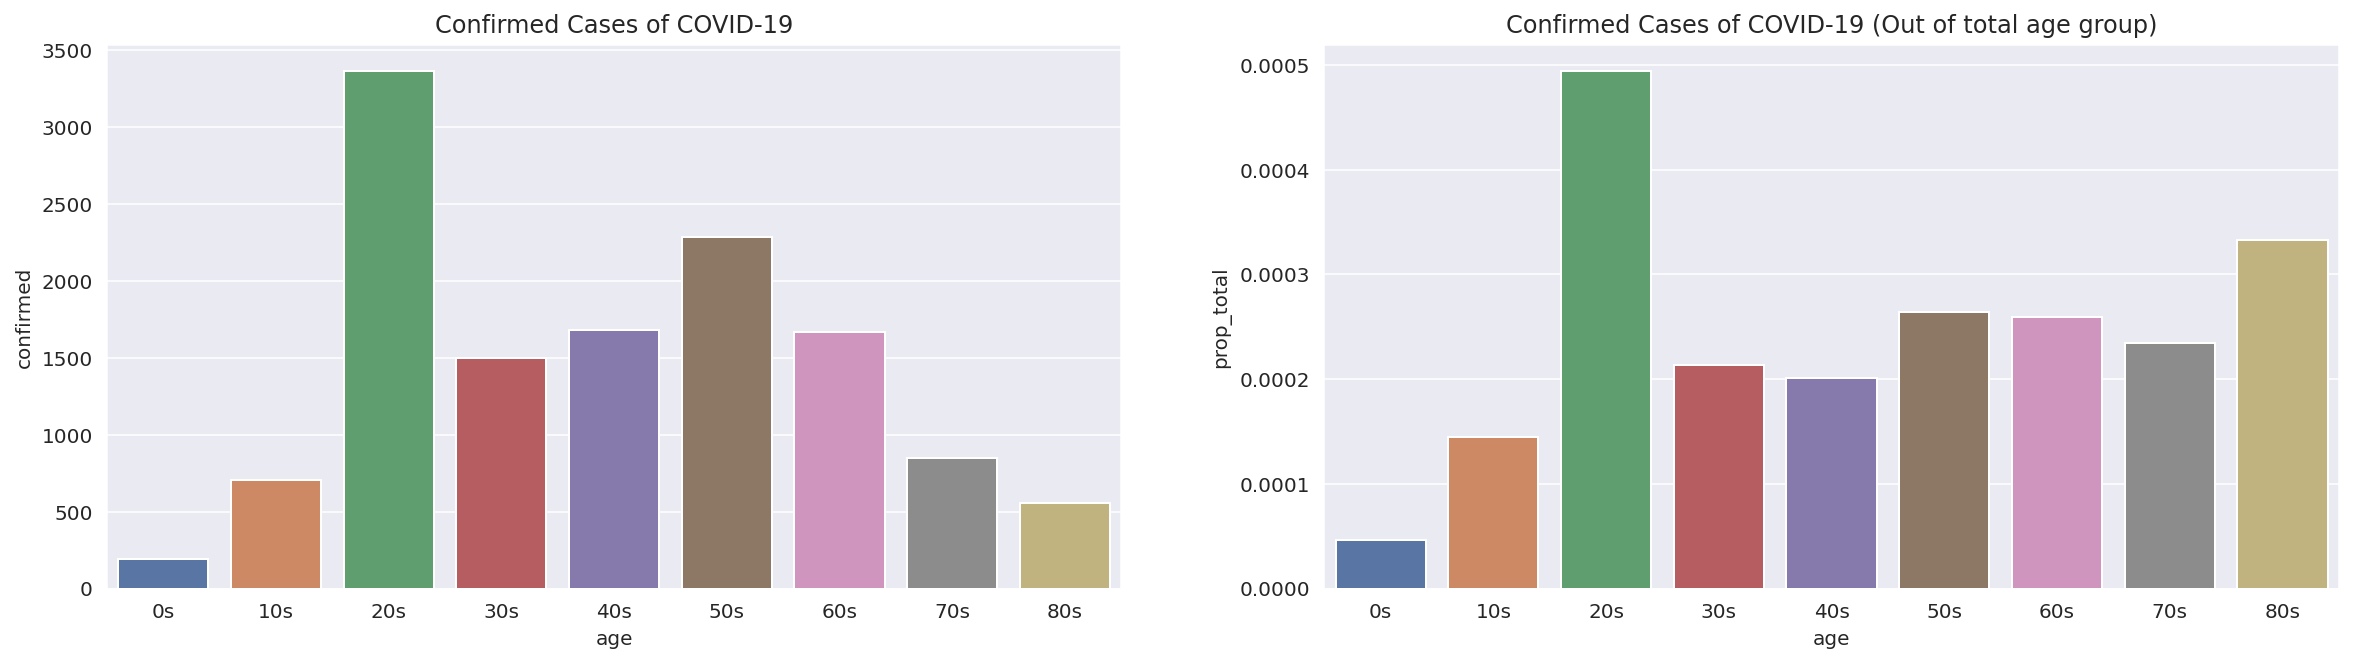

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases of COVID-19')
sns.barplot(data=age[-9:], x='age', y='confirmed', ax=ax1)

# Create new column of total people in that age group
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')
age['age_total'] = np.tile(pop_dist_age, len(age) // len(pop_dist_age) + 1)[:len(age)]

# Create proportion column
age['prop_total'] = age['confirmed'] / age['age_total'].astype(float)

# Proportion of confirmed cases by age to total people in age group
ax2.title.set_text('Confirmed Cases of COVID-19 (Out of total age group)')
sns.barplot(data=age[-9:], x='age', y='prop_total', ax=ax2)

plt.show()

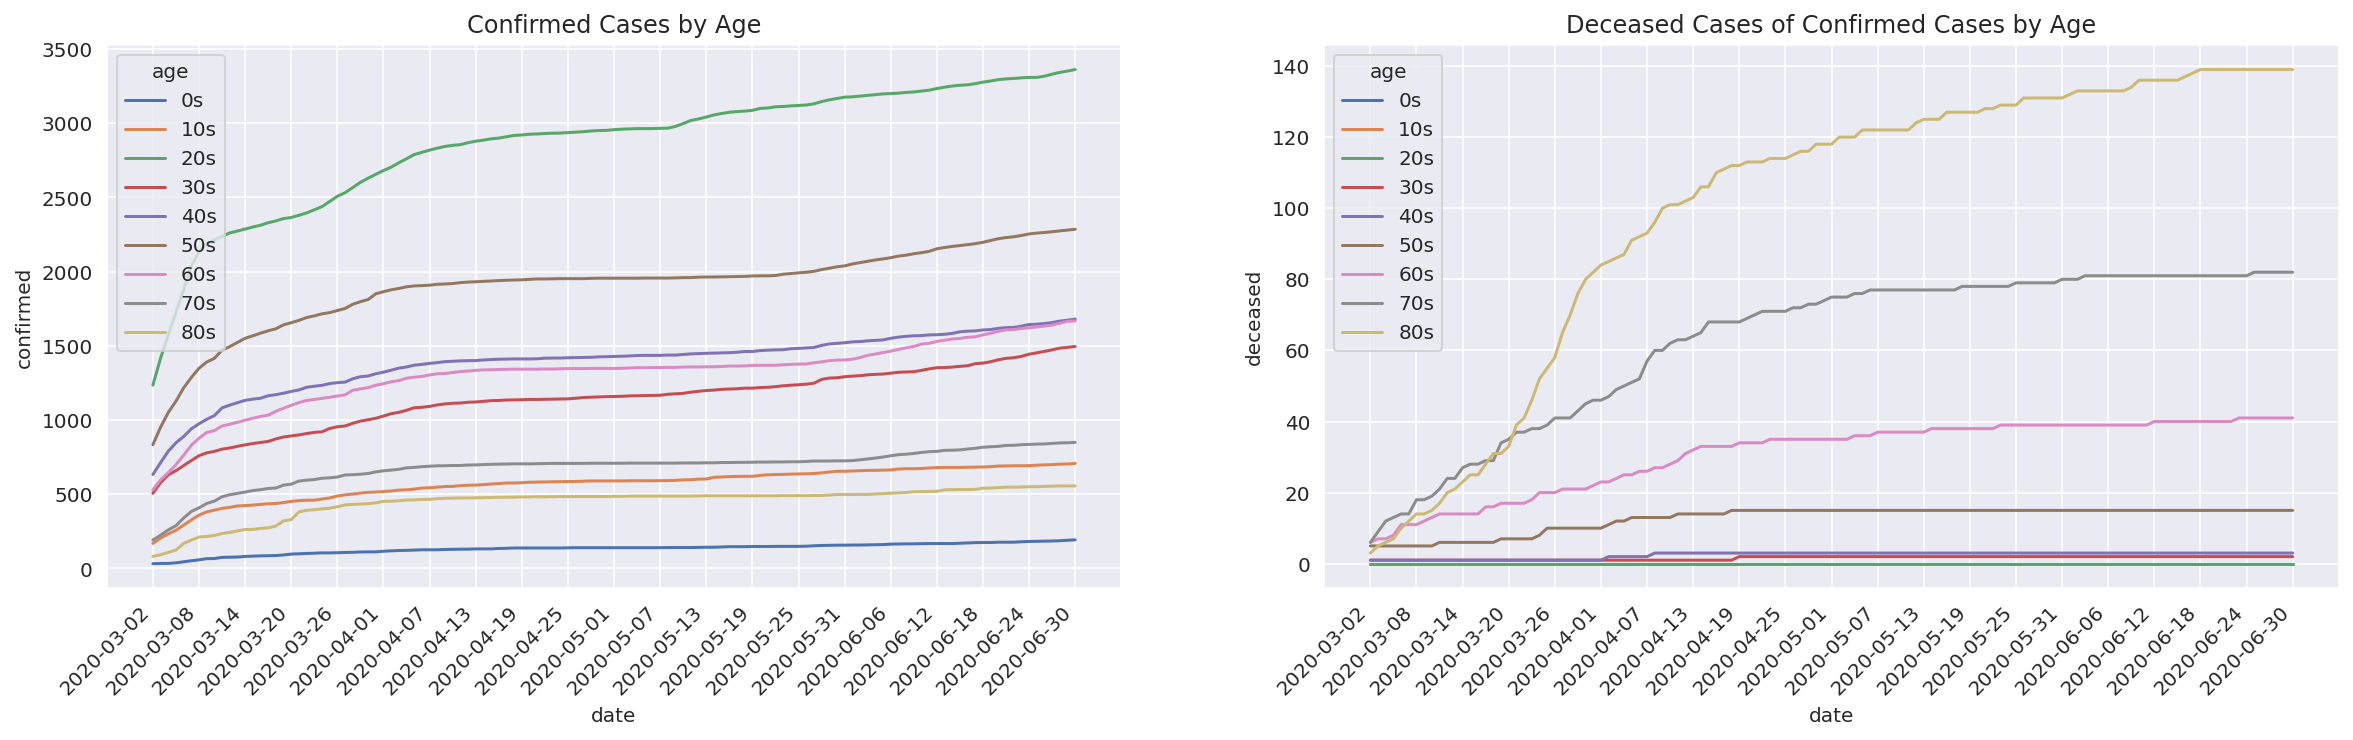

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='confirmed', hue='age', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Deceased cases by age
ax2.title.set_text('Deceased Cases of Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='deceased', hue='age', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.xticks(rotation=45, ha='right')

plt.show()

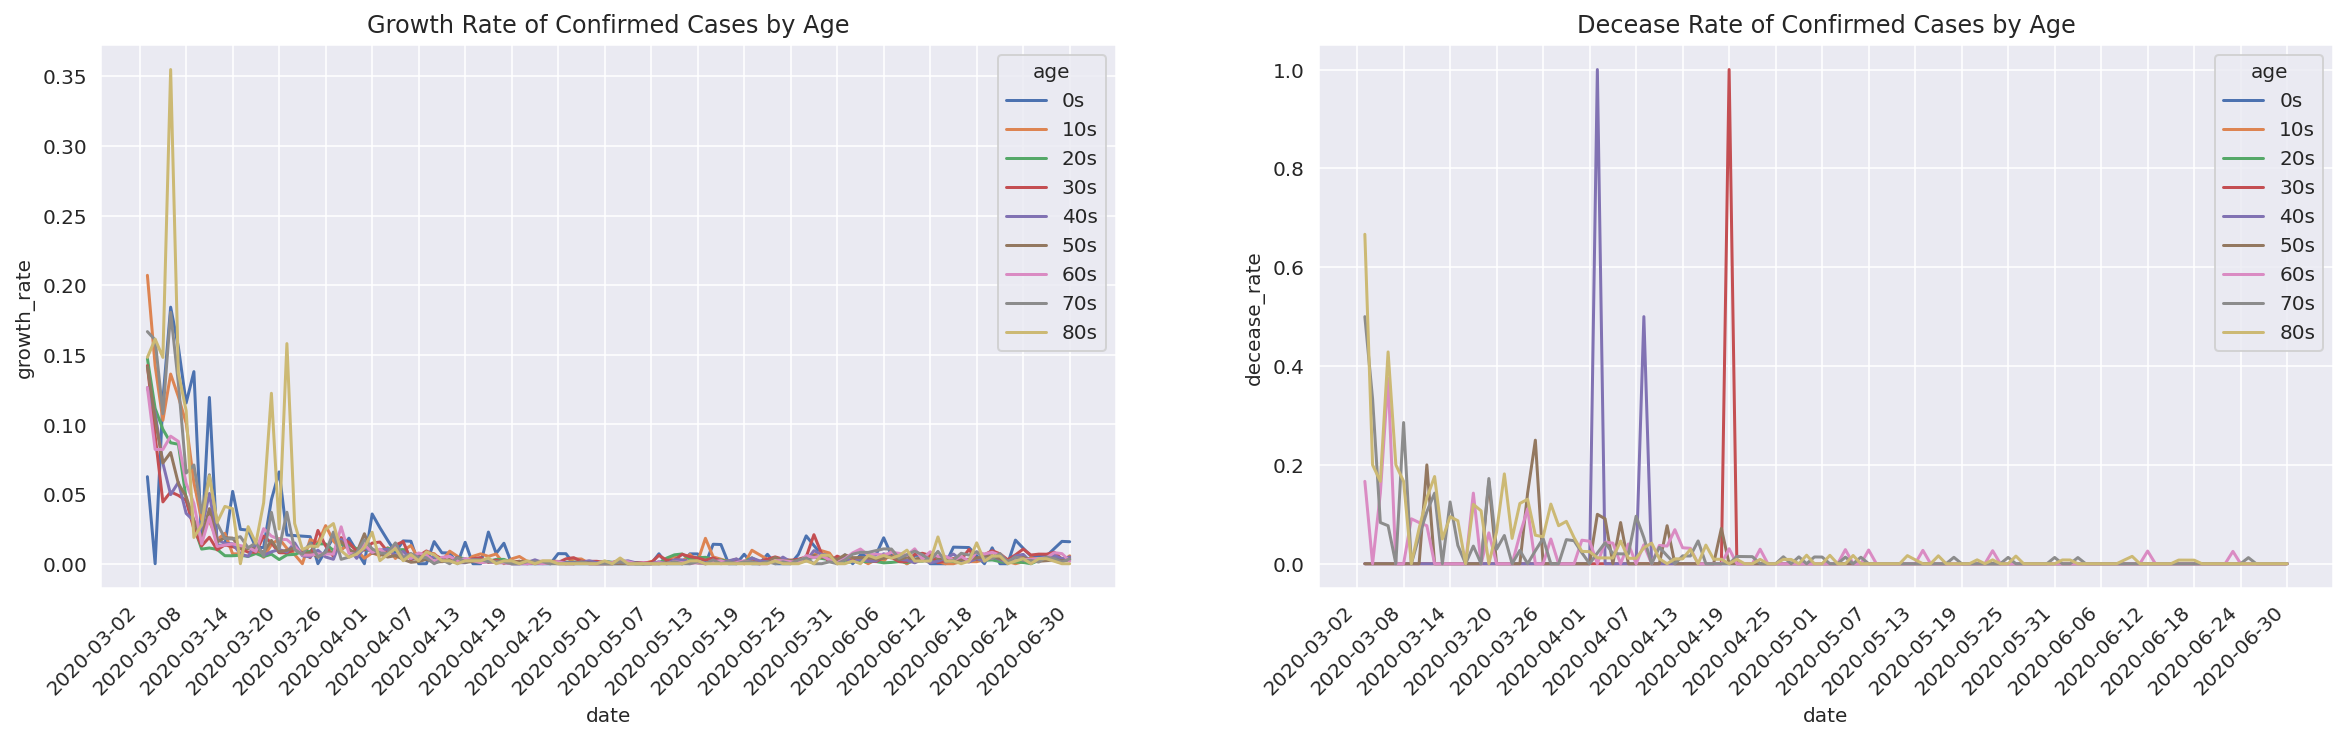

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases
ax1.title.set_text('Growth Rate of Confirmed Cases by Age')
age['growth_rate'] = age.groupby('age')[['confirmed']].pct_change()
sns.lineplot(data=age, x='date', y='growth_rate', hue='age', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Age')
age['decease_rate'] = age.groupby('age')[['deceased']].pct_change()
sns.lineplot(data=age, x='date', y='decease_rate', hue='age', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.xticks(rotation=45, ha='right')

plt.show()

**Analysis & Conclusion**

Although 20s only take up 13.2% of all populations in South Korea, they are the most infected and has the highest infection rate among all other age groups.
Older people are more prone to get COVID-19 and are more likely to get deceased.
Trend of growth and decease rate seems similar.
Age seems to be a significant feature that influences infection rate.

High infection rate of age group 20s can might be explained by their social activeness as young people tend to move around places more than older people. As people get older, their immunity tends to drop, which might be the reason why there are more cases of infections as people age.

*** By Location ***

In [22]:
# Importing data: Location
location = pd.read_csv('TimeProvince.csv')
prov_num = len(location['province'].unique())
print(f'There are {prov_num} provinces in this dataset')

# Latest data of confirmed cases by province
loc_latest = location.iloc[-prov_num:]
loc_latest = loc_latest.sort_values('confirmed', ascending=False).reset_index(
                        drop=True).drop('time', axis=1)
loc_latest

There are 17 provinces in this dataset


date           province  confirmed  released  deceased
0   2020-06-30              Daegu       6906      6700       189
1   2020-06-30   Gyeongsangbuk-do       1389      1328        54
2   2020-06-30              Seoul       1312       985         7
3   2020-06-30        Gyeonggi-do       1207       931        23
4   2020-06-30            Incheon        341       290         1
5   2020-06-30  Chungcheongnam-do        167       150         0
6   2020-06-30              Busan        154       142         3
7   2020-06-30   Gyeongsangnam-do        134       128         0
8   2020-06-30            Daejeon        117        44         1
9   2020-06-30         Gangwon-do         65        54         3
10  2020-06-30  Chungcheongbuk-do         65        60         0
11  2020-06-30              Ulsan         55        50         1
12  2020-06-30             Sejong         50        47         0
13  2020-06-30            Gwangju         44        32         0
14  2020-06-30       Jeollabuk-do         27        21         0
15  2020-06-30       Jeollanam-do         24        19         0
16  2020-06-30            Jeju-do         19        16         0

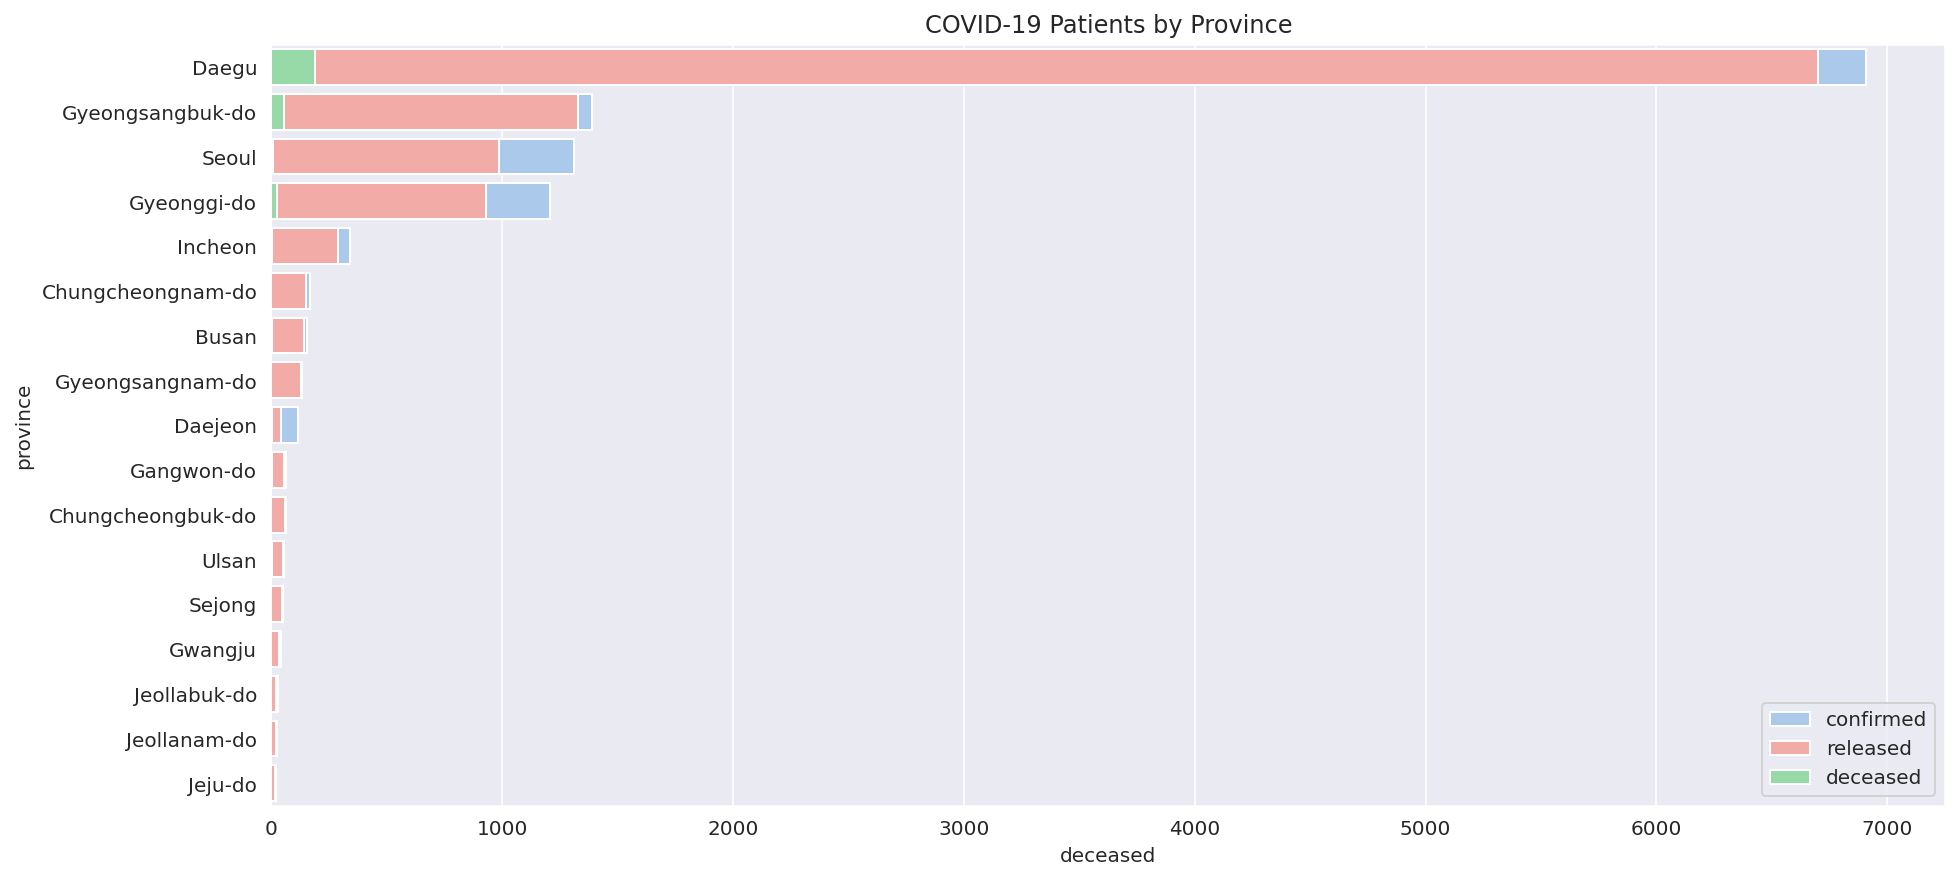

In [23]:
# Latest number of confirmed & released & deceased people
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.title.set_text('COVID-19 Patients by Province')
sns.set_color_codes("pastel")
sns.barplot(data=loc_latest, x='confirmed', y='province',  label='confirmed',
            color='b', ci=None, estimator=sum)
sns.barplot(data=loc_latest, x='released', y='province', label='released',
            color='r', ci=None, estimator=sum)
sns.barplot(data=loc_latest, x='deceased', y='province', label='deceased',
            color='g', ci=None, estimator=sum)
ax1.legend(loc='lower right', frameon=True)
fig.show()

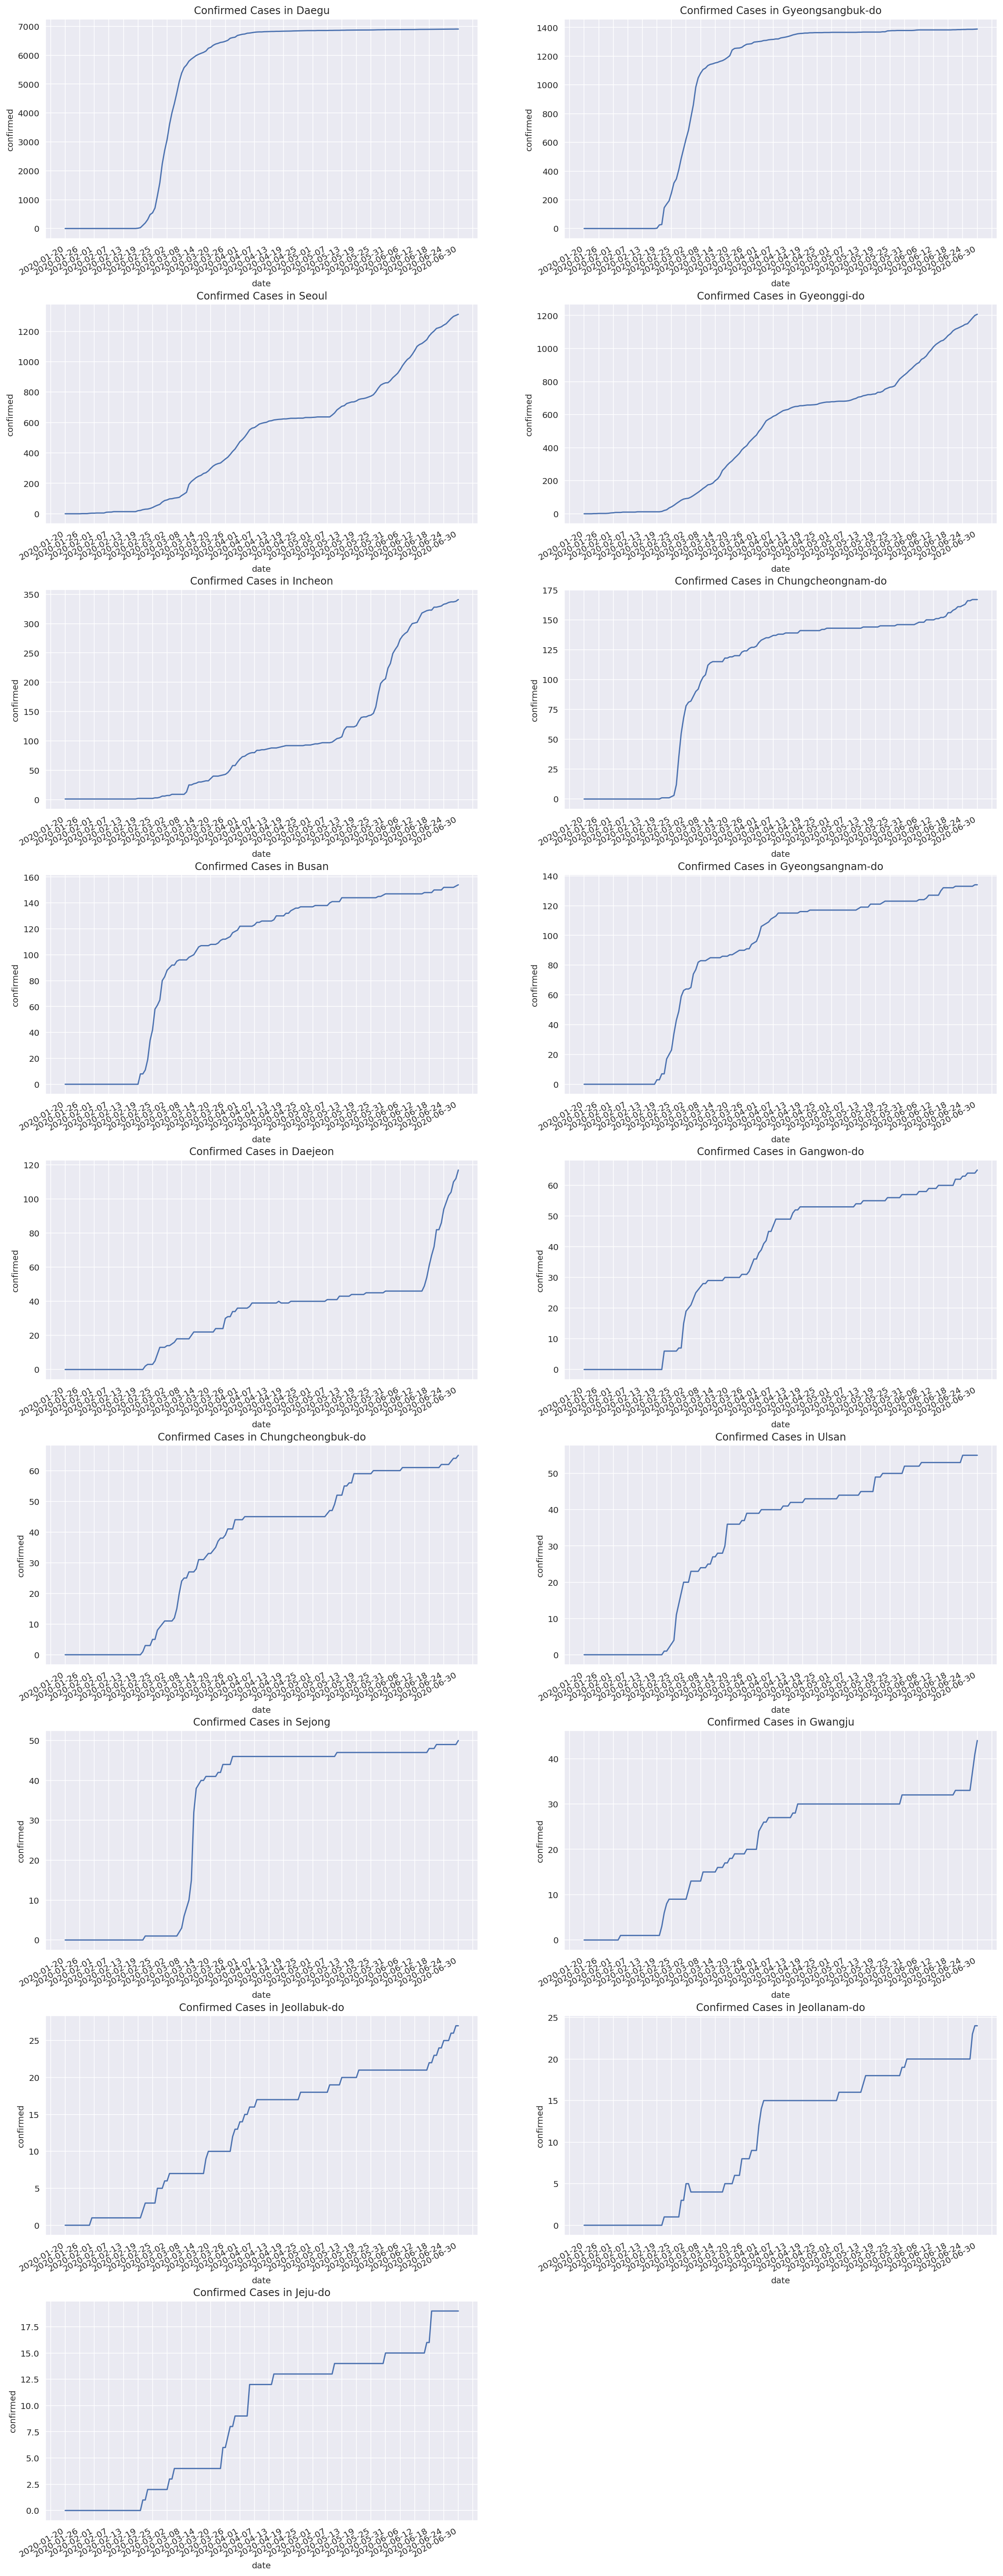

In [24]:
# Confirmed cases in each province (accumulated)
rows = int(prov_num / 2 + 1)
fig, ax = plt.subplots(rows, 2, figsize=(20, 6 * rows))
fig.subplots_adjust(hspace=.3)

for i, province in enumerate(loc_latest['province']):
    r, c = int(i / 2), i % 2
    sns.lineplot(data=location[location['province'] == province],
                 x='date', y='confirmed', ax=ax[r, c])
    ax[r, c].set_title(f'Confirmed Cases in {province}')
    ax[r, c].xaxis.set_major_locator(ticker.MultipleLocator(base=6))
    plt.setp(ax[r, c].xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.delaxes(ax[rows - 1][rows * 2 - prov_num])
fig.show()

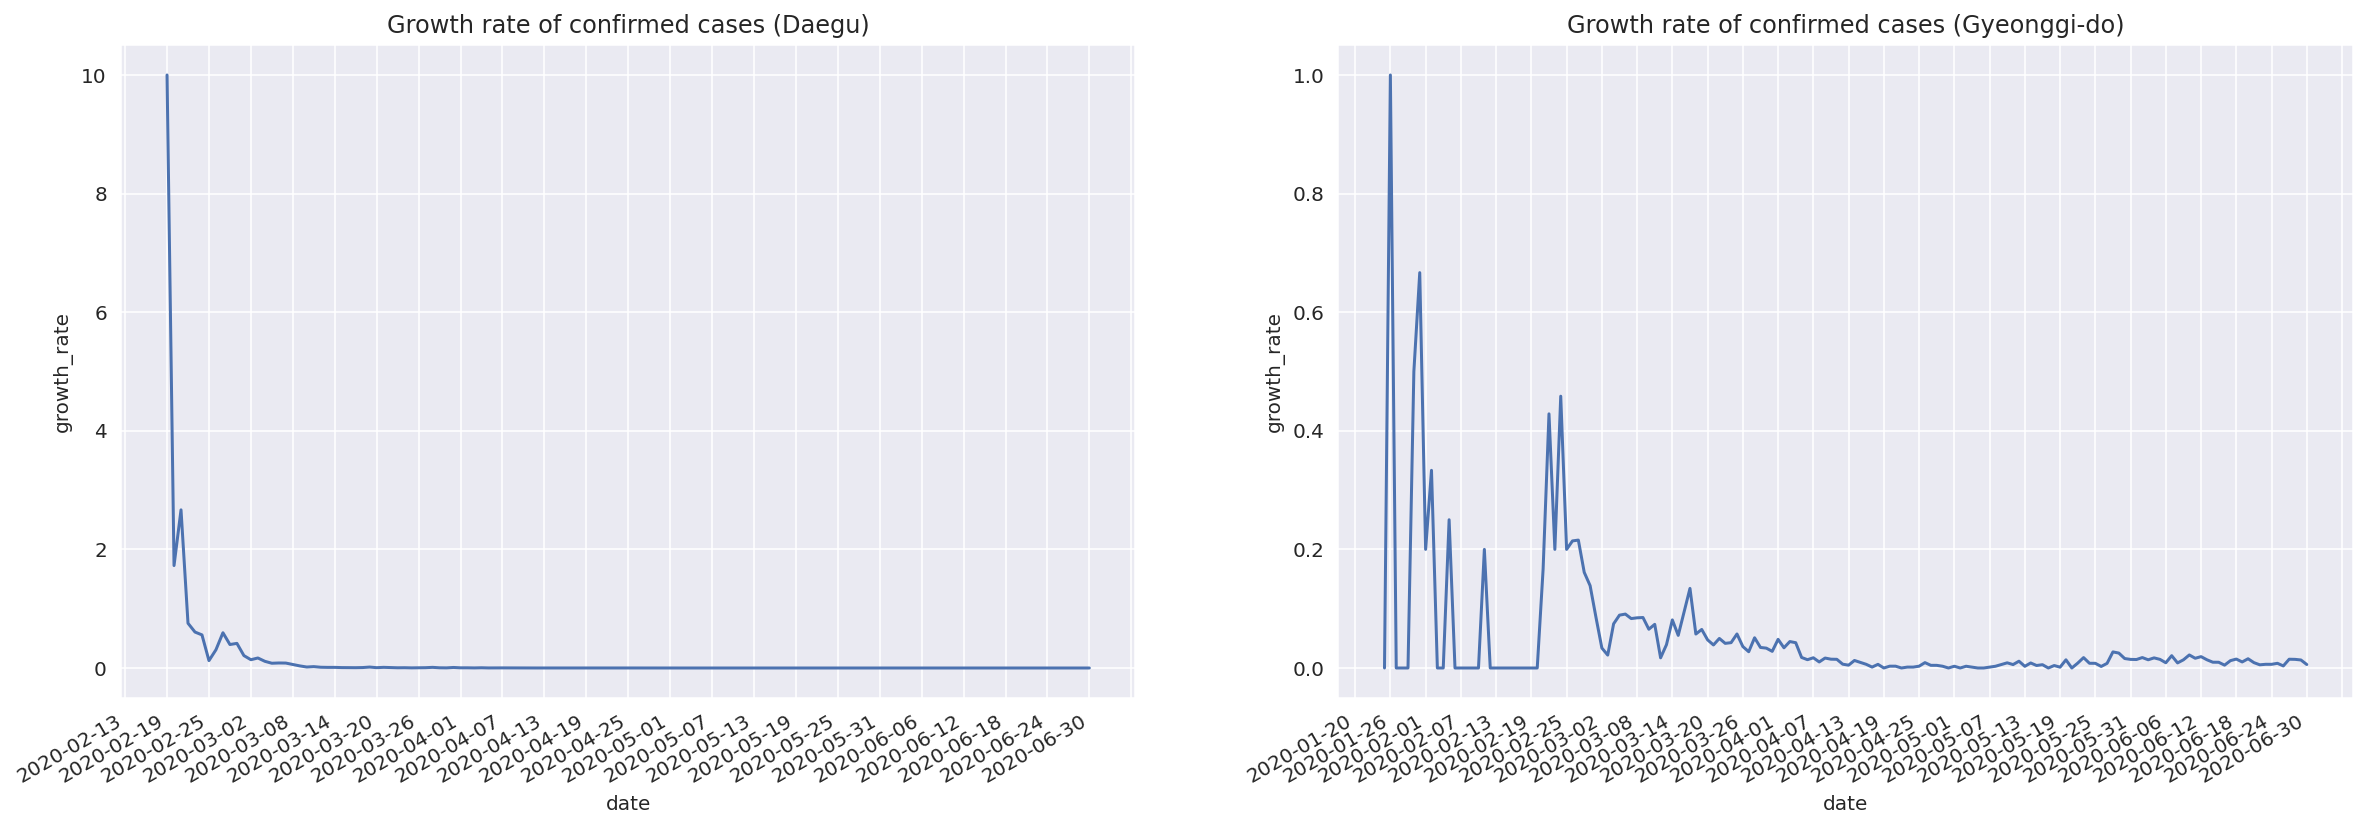

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
location['growth_rate'] = location.groupby('province')[['confirmed']].pct_change()

# Growth rate of confirmed cases in Daegu
ax1.set_title('Growth rate of confirmed cases (Daegu)')
sns.lineplot(data=location[location['province'] == 'Daegu'], x='date', y='growth_rate', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Growth Rate of confirmed cases in Gyeonggi-do
ax2.set_title('Growth rate of confirmed cases (Gyeonggi-do)')
sns.lineplot(data=location[location['province'] == 'Gyeonggi-do'], x='date', y='growth_rate', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()

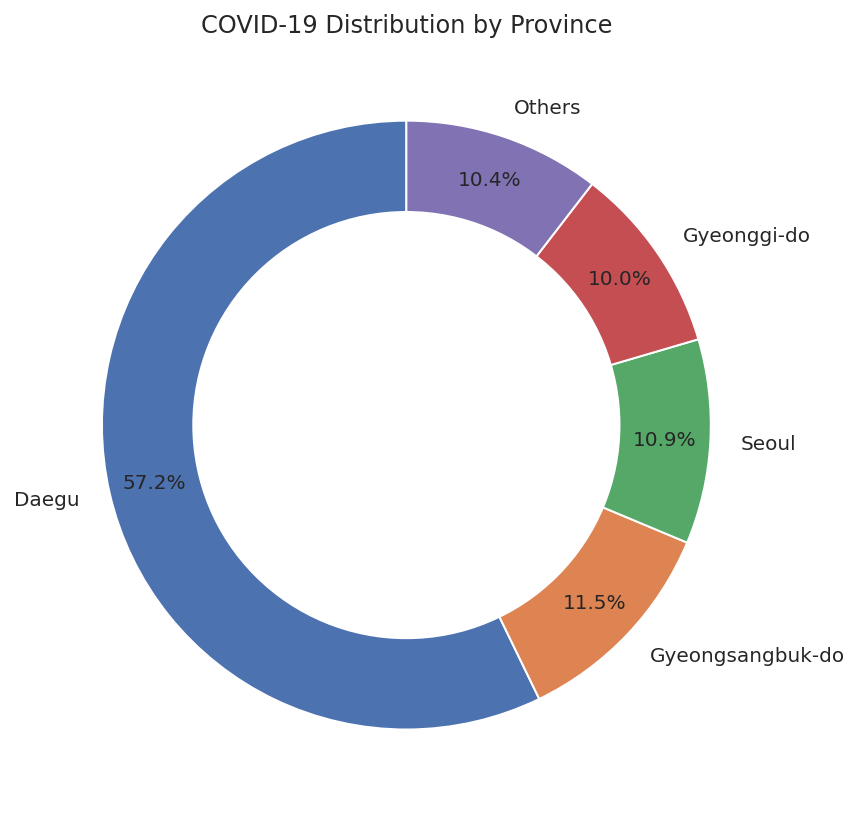

In [26]:
# Proportion out of total confirmed cases by province
loc_latest['proportion'] = round(loc_latest['confirmed'] / sum(loc_latest['confirmed']) * 100, 2)

# Combine provinces that consists less than 2% of total cases
loc_latest.loc['17',:] = loc_latest.iloc[4:, :].sum()
loc_latest.loc['17',['date', 'province']] = ['2020-03-30', 'Others']

sns.set_palette('deep')
loc_latest_w_etc = loc_latest.iloc[[0, 1, 2, 3, 17], [1, 5]]

# COVID-19 distribution by province
plt.figure(figsize=(7, 7))
plt.title('COVID-19 Distribution by Province')
plt.pie(loc_latest_w_etc['proportion'], labels=loc_latest_w_etc['province'], 
        autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))
plt.show()

In [28]:
# Importing data: Region
region = pd.read_csv('Region.csv')
region = region.drop('nursing_home_count', axis=1)
# region = region.drop(['latitude', 'longitude', 'nursing_home_count'], axis=1)
# Drop column with same value and sort by academy_ratio
region_overview = region[region['province'] == region['city']].drop('city',
                  axis=1).drop(243).sort_values('academy_ratio', 
                  ascending=False).reset_index(drop=True)
region_overview.head()

code          province  ...  elderly_population_ratio  elderly_alone_ratio
0  13000           Gwangju  ...                     13.57                  6.4
1  16000             Ulsan  ...                     11.76                  5.2
2  50000      Jeollabuk-do  ...                     20.60                 10.9
3  17000            Sejong  ...                      9.48                  3.8
4  61000  Gyeongsangnam-do  ...                     16.51                  9.1

[5 rows x 10 columns]

In [29]:
# Add latitude and longtitude
loc_latest = loc_latest.merge(
    region_overview[['province', 'latitude','longitude']],
    on = 'province')
loc_latest['latitude'] = loc_latest['latitude'].astype(float)
loc_latest['longitude'] = loc_latest['longitude'].astype(float)
loc_latest.head()

date          province  confirmed  ...  proportion   latitude   longitude
0  2020-06-30             Daegu     6906.0  ...       57.19  35.872150  128.601783
1  2020-06-30  Gyeongsangbuk-do     1389.0  ...       11.50  36.576032  128.505599
2  2020-06-30             Seoul     1312.0  ...       10.86  37.566953  126.977977
3  2020-06-30       Gyeonggi-do     1207.0  ...       10.00  37.275119  127.009466
4  2020-06-30           Incheon      341.0  ...        2.82  37.456188  126.705920

[5 rows x 8 columns]

In [40]:
# COVID-19 infection distribution
map_southKR = folium.Map(location=[35.9, 128], tiles="cartodbpositron",
                         zoom_start=7, max_zoom=10, min_zoom=7)
folium.Choropleth(geo_data='province_geo.json', 
                  fill_color='#ffff66', line_opacity=0.5, fill_opacity=0.3).add_to(map_southKR)

for i in range(0, len(loc_latest)):
    folium.Circle(location=[loc_latest.iloc[i]['latitude'], loc_latest.iloc[i]['longitude']],
                  tooltip="<h5 style='text-align:center;font-weight: bold'>" + 
                  loc_latest.iloc[i]['province'] + "</h5><hr style='margin:10px;'>" +
                  "<ul style='align-item:left;padding-left:20px;padding-right:20px'>" +
                  "<li>Confirmed: " + str(loc_latest.iloc[i]['confirmed']) + "</li>" +
                  "<li>Deaths: " + str(loc_latest.iloc[i]['deceased']) + "</li>" +
                  "<li>Mortality Rate: " + str(round(loc_latest.iloc[i]['deceased'] /
                                                     (loc_latest.iloc[i]['confirmed'] + .000001) * 100, 2)) + 
                  "%</li></ul>",
                  radius=int((np.log(loc_latest.iloc[i]['confirmed'])))*5000,
                  color='#ff3333',
                  fill_color='#ff0000',
                  fill=True).add_to(map_southKR)

map_southKR

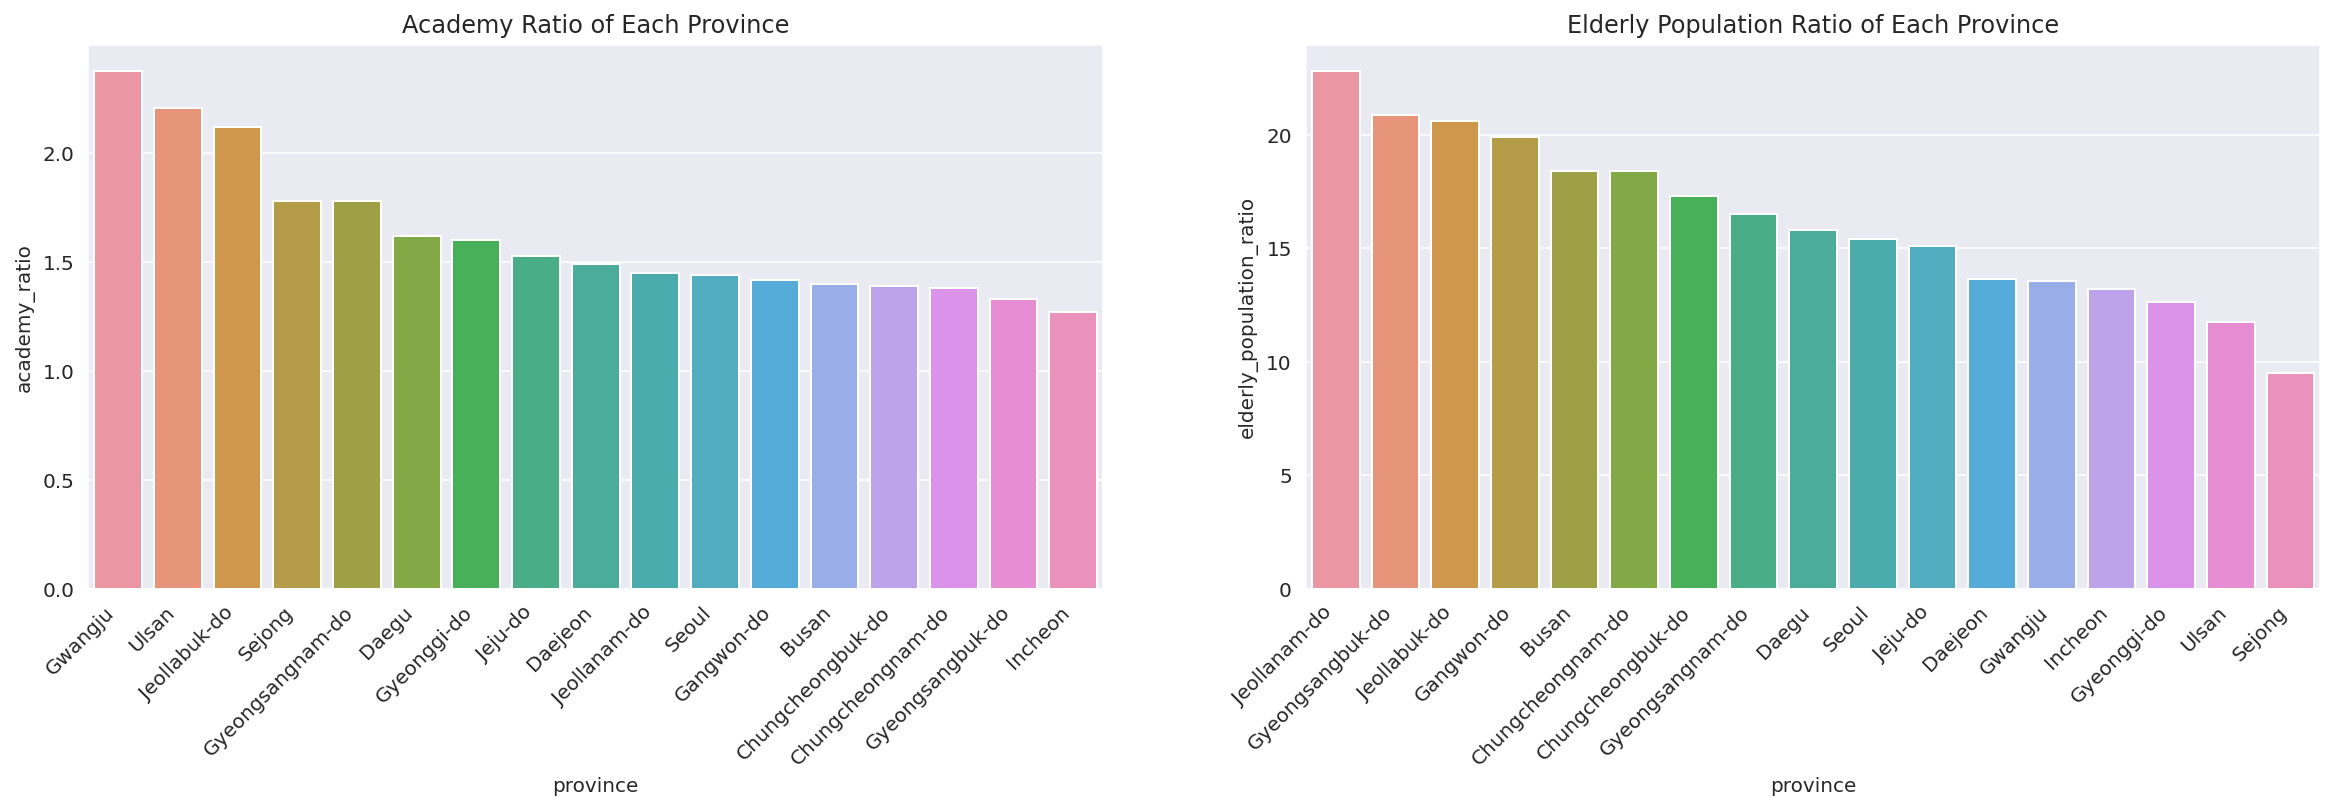

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Academy ratio of each province
ax1.title.set_text('Academy Ratio of Each Province')
sns.barplot(data=region_overview, x='province', y='academy_ratio', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

region_overview = region_overview.sort_values('elderly_population_ratio', 
                                              ascending=False).reset_index(drop=True)

# Elderly population ratio of each province
ax2.title.set_text('Elderly Population Ratio of Each Province')
sns.barplot(data=region_overview, x='province', y='elderly_population_ratio', ax=ax2)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.show()

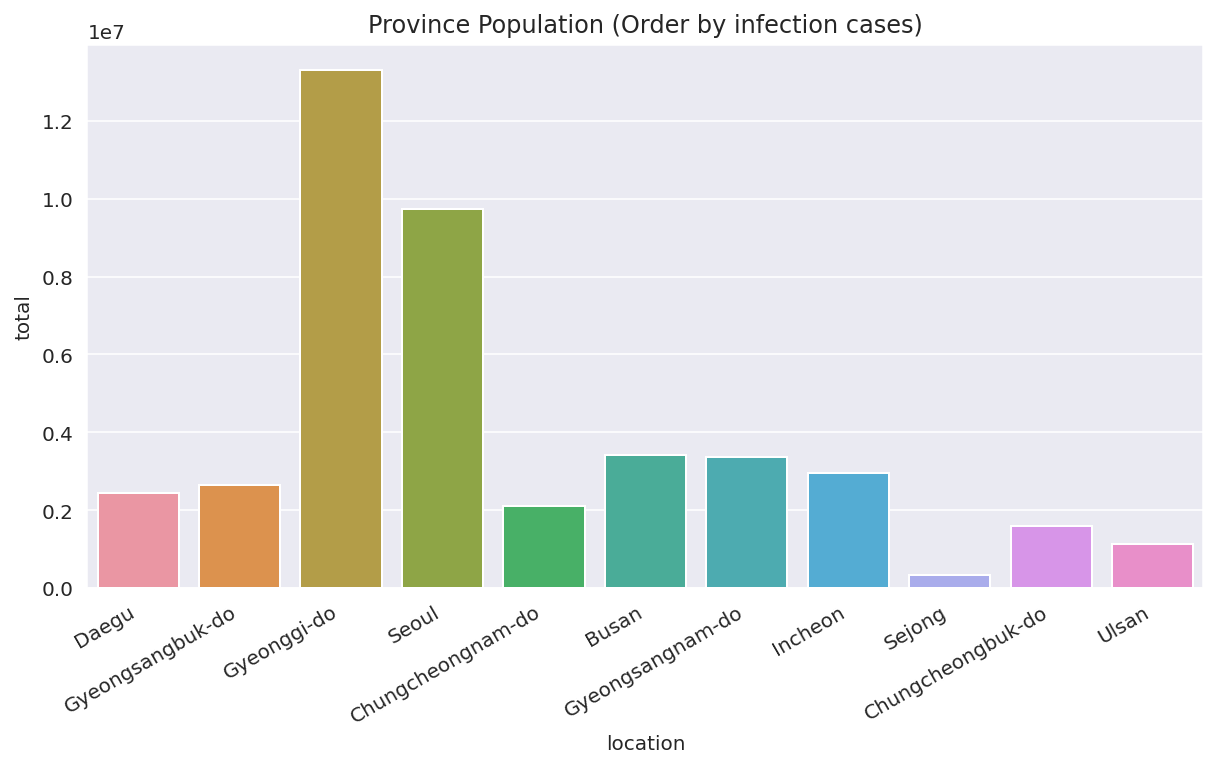

In [42]:
# DataFrame only with province and population value
pop_dist_prov = pop_dist.copy(deep=True)
pop_dist_prov['total'] = pop_dist_prov['total'].str.replace(',', '').astype(int)
pop_dist_prov = pop_dist_prov.sort_values('total', ascending=False).reset_index(
    drop=True).drop(pop_dist_prov.columns[2:13], axis=1)
by_i_case = pop_dist_prov.loc[[7, 6, 1, 2, 8, 3, 4, 5, 17, 11, 15], :]
by_i_case['location'] = ['Daegu','Gyeongsangbuk-do','Gyeonggi-do','Seoul',
                 'Chungcheongnam-do','Busan','Gyeongsangnam-do','Incheon',
                 'Sejong','Chungcheongbuk-do','Ulsan']

# Province population ordered by infection cases
plt.figure(figsize=(10, 5))
plt.title('Province Population (Order by infection cases)')
sns.barplot(data=by_i_case, x='location', y='total')
plt.xticks(rotation=30, ha='right')
plt.show()

**Analysis & Conclusion**

Less than 100 people were infected for the first month but infection case has grown exponentially for the following months.
Top 3 provinces with high COVID-19 infection take up 90% of total cases.
It seems COVID-19 has gone to a lull (Slope is decreasing) in provinces except Gyeonggi-do, Seoul, and Incheon.
The infection growth rate in Gyeonggi-do shows several spikes, which means there were a sudden increase in infection cases that might have been caused by collective infection due to an event or work.
Academy ratio and elderly population ratio of a province seem to have no correlation with infection cases in particular province.
There tends to be more confirmed cases of COVID-19 in provinces with high popultaion except Daegu and Gyeongsangbuk-do.
Location seems to be a significant feature that influences infection rate.

However, it seems location is not the major factor that determines the infection rate.
The reason why Daegu and Gyeongsangbuk-do have a high number of patients relative to their population are because infected Sincheonji believers had a huge prayer meeting, causing of exponential growth, and many of them traveled from Daegu to Gyeongsangbuk-do.

*** By Time *** 

In [43]:
# Importing data: Time
time = pd.read_csv('Time.csv')
time.head()

date  time  test  negative  confirmed  released  deceased
0  2020-01-20    16     1         0          1         0         0
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0

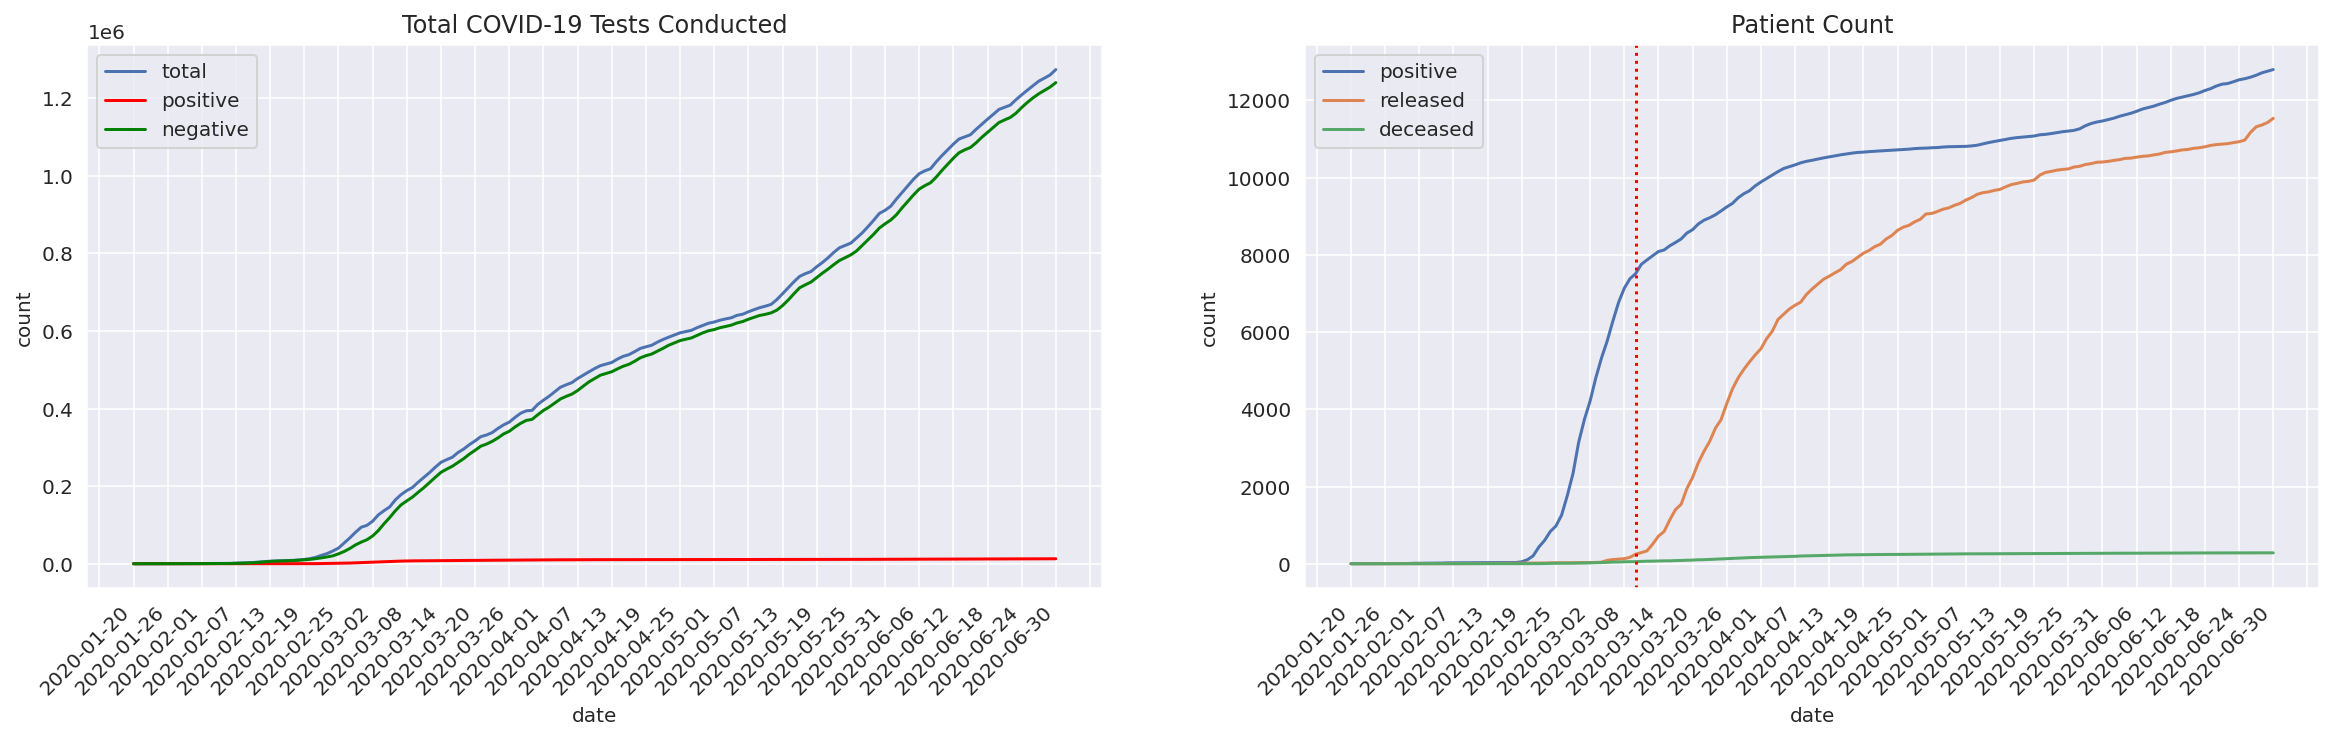

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Number of tests conducted
ax1.title.set_text('Total COVID-19 Tests Conducted')
sns.lineplot(data=time, x='date', y='test', label='total', ax=ax1)
sns.lineplot(data=time, x='date', y='confirmed', color='red', label='positive', ax=ax1)
sns.lineplot(data=time, x='date', y='negative', color='green', label='negative', ax=ax1)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
ax1.set(ylabel='count')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Positive & Released & Deceased cases
ax2.title.set_text('Patient Count')
sns.lineplot(data=time, x='date', y='confirmed', label='positive', ax=ax2)
sns.lineplot(data=time, x='date', y='released', label='released', ax=ax2)
sns.lineplot(data=time, x='date', y='deceased', label='deceased', ax=ax2)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
ax2.set(ylabel='count')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Draw vertical line in patient count graph
ax2.axvline('2020-03-10', 0, 10000, color='red', linestyle='dotted')

plt.show()

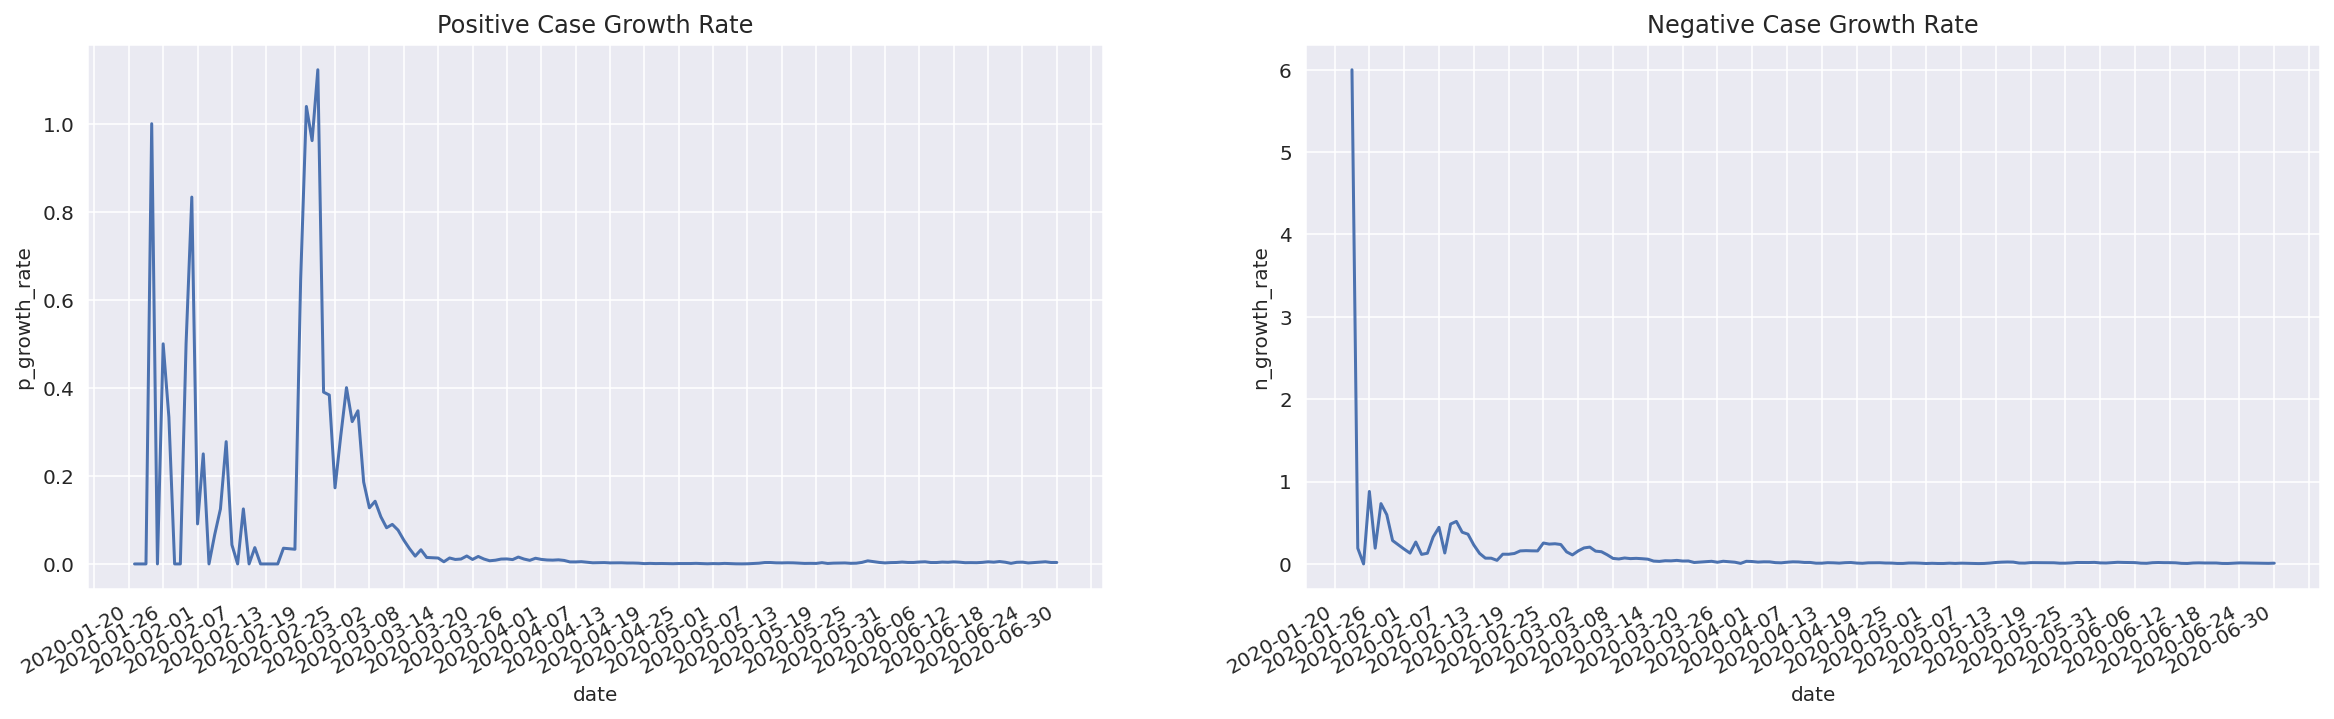

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
time['p_growth_rate'] = time['confirmed'].pct_change()
time['n_growth_rate'] = time['negative'].pct_change()

# Growth rate of positive cases
ax1.set_title('Positive Case Growth Rate')
sns.lineplot(data=time, x='date', y='p_growth_rate', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Growth rate of negative cases
ax2.set_title('Negative Case Growth Rate')
sns.lineplot(data=time, x='date', y='n_growth_rate', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()

In [46]:
# Proportion by total population
time_f = time.tail(1)
time_latestT = time_f.test.values[0]
time_latestP = time_f.confirmed.values[0]
time_latestN = time_f.negative.values[0]
pop_total = int(pop_dist.iat[0, 1].replace(',', ''))

print('Percentage of people tested out of total population: {0}%\n'.format(round(time_latestT / pop_total * 100, 2)) + 
      'Percentage of positive cases out of people tested: {0}%\n'.format(round(time_latestP / time_latestT * 100, 2)) + 
      'Percentage of negative cases out of people tested: {0}%'.format(round(time_latestN / time_latestT * 100, 2)))

Percentage of people tested out of total population: 2.46%
Percentage of positive cases out of people tested: 1.0%
Percentage of negative cases out of people tested: 97.36%


**Analysis & Conclusion**

Total number of conducted tests and negative results are increasing linearly while the rate of positive results is slowly decreasing unlike its exponential growth in the first.
Since 2020-03-10, rate of positive results is decreasing and rate of released patients is increasing rapidly.
From spikes in the positive case growth rate, we can infer some event has happened just before, causing collective infection.
A Graph of time vs infection cases follows the SIR epidemic model.

*** By Search Trend ***

In [48]:
# Importing data: Search Trend
searchtrend = pd.read_csv('SearchTrend.csv')
searchtrend.head()

date     cold      flu  pneumonia  coronavirus
0  2016-01-01  0.11663  0.05590    0.15726      0.00736
1  2016-01-02  0.13372  0.17135    0.20826      0.00890
2  2016-01-03  0.14917  0.22317    0.19326      0.00845
3  2016-01-04  0.17463  0.18626    0.29008      0.01145
4  2016-01-05  0.17226  0.15072    0.24562      0.01381

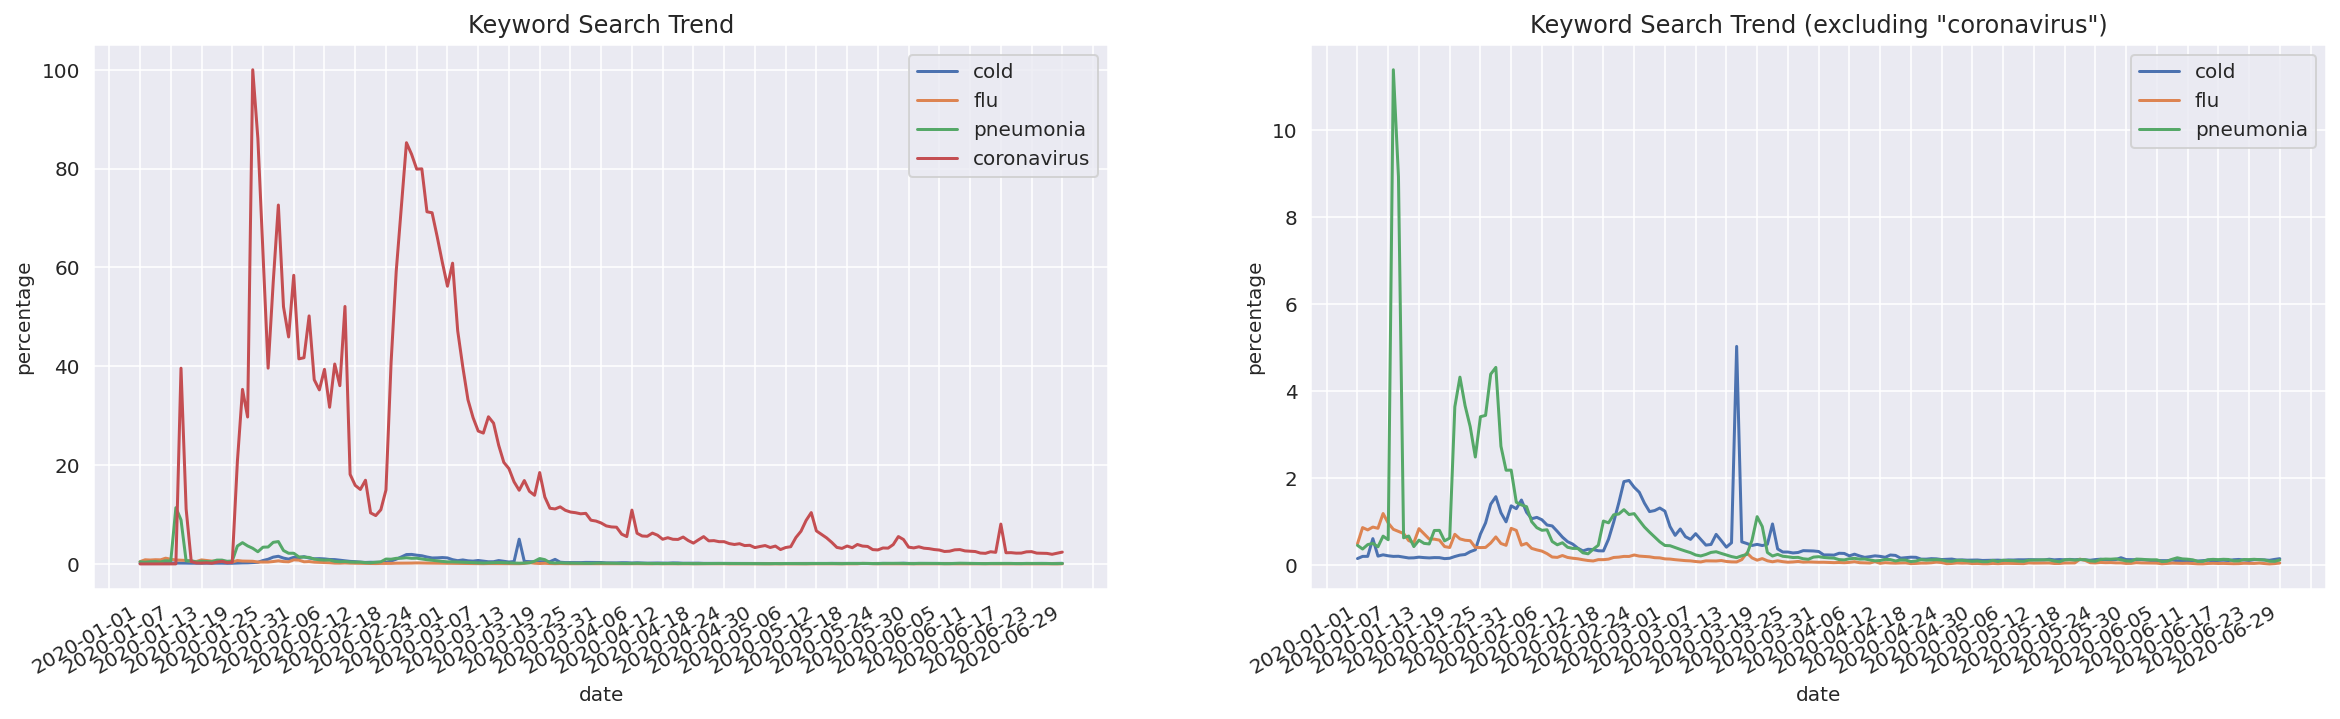

In [49]:
searchTrend_2020 = searchtrend.iloc[1461:, :]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Search proportion of keywords related to COVID-19
ax1.title.set_text('Keyword Search Trend')
for keyword in searchTrend_2020.iloc[:, 1:].columns:
    sns.lineplot(data=searchTrend_2020, x='date', y=keyword, label=keyword, ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
ax1.set(ylabel='percentage')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

# Search proportion of keywords related to COVID-19 except coronavirus
ax2.title.set_text('Keyword Search Trend (excluding "coronavirus")')
sns.lineplot(data=searchTrend_2020, x='date', y='cold', label='cold', ax=ax2)
sns.lineplot(data=searchTrend_2020, x='date', y='flu', label='flu', ax=ax2)
sns.lineplot(data=searchTrend_2020, x='date', y='pneumonia', label='pneumonia', ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=6))
ax2.set(ylabel='percentage')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

fig.show()

**Analysis & Conclusion**

Between Jan 8, 2020 and Jan 11, 2020, there were sudden spike of keyword search related to coronavirus.
After Jan 11, 2020, people searched less for cold, flu, and pneumonia and percentage of coronavirus searched through NAVER (top online portal in KR) increased rapidly starting from Jan 9, 2020, maintaining its search frequency over 50% most of the time until March 4, 2020.
We can assume people first became aware of corona virus at Jan 8, 2020 and people's awareness became high when the first COVID-19 patient was spotted in South Korea at Jan 20, 2020.
We can see that search trend of coronavirus has once again spiked in Feb 18, 2020, as number of confirmed cases suddenly grew exponentially.
However, corona virus is receiving less attention since new confirmed cases of COVID-19 have decreased significantly compared to previous days. (new cases < 30)
People tend to search keywords related to COVID-19 when it was first brought to spotlight, when first death case happened, and when there was significant increase in growth rate of confirmed cases.

*** By Patient ***

In [51]:
# Importing data: Patient info
patientinfo = pd.read_csv('PatientInfo.csv')
p_total = len(patientinfo)
print('People mainly got infected by {0} ways'.format(len(patientinfo['infection_case'].unique())) + 
      ' and had {0} contacts per person in average.'.format(round(patientinfo['contact_number'].mean(), 2)))
print('There are {0} patient data in this set.'.format(p_total))

# Convert to Int64 to remove decimals and leave NaN
patientinfo['infected_by'] = patientinfo['infected_by'].astype('Int64')

# Show transpose of a matrix for better visualization
patientinfo.head().T

TypeError: ignored

KeyError: ignored

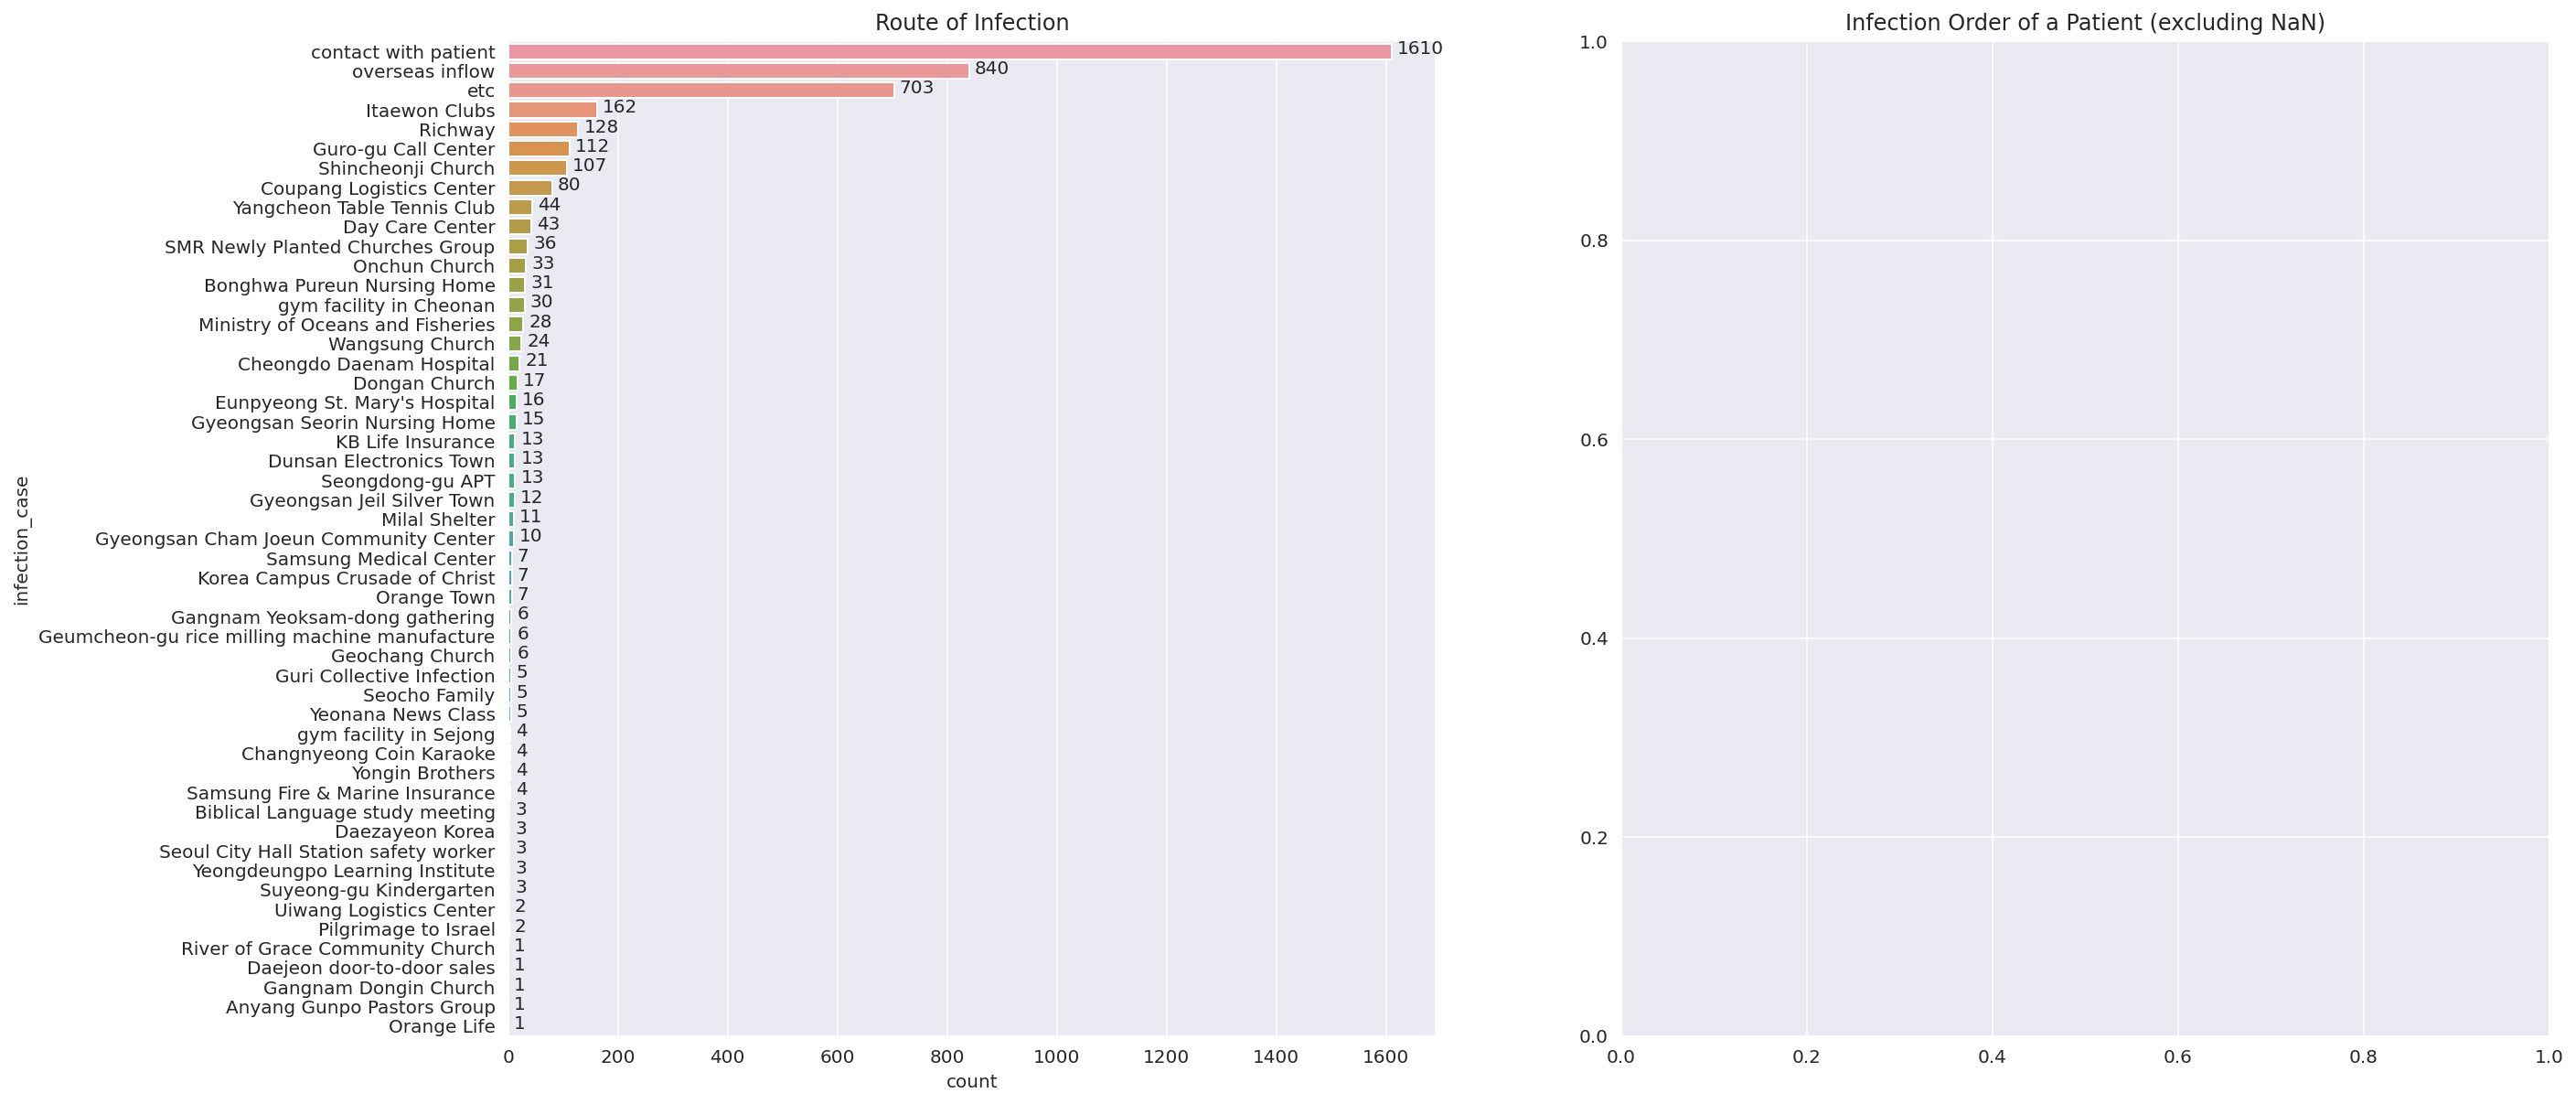

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Where/How confirmed patients got infected
ax1.title.set_text('Route of Infection')
sns.countplot(data=patientinfo, y='infection_case', 
              order=patientinfo['infection_case'].value_counts().index, ax=ax1)
show_values_on_bars(ax1, 'h', 10, 0.25)

# Infection order of a patient
ax2.title.set_text('Infection Order of a Patient (excluding NaN)')
sns.countplot(data=patientinfo, x='infection_order',
              order=patientinfo['infection_order'].value_counts().index, ax=ax2)
show_values_on_bars(ax2, 'v', modv=0.2)

plt.show()

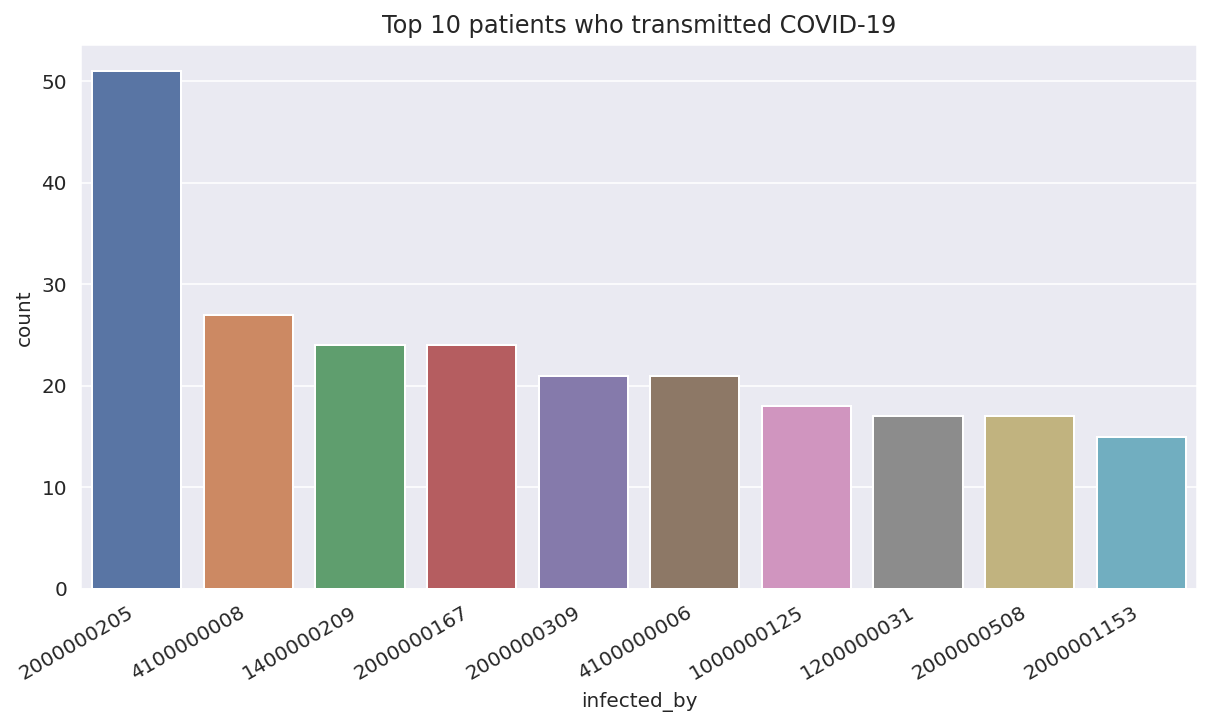

In [53]:
transmit_order = patientinfo['infected_by'].value_counts().iloc[:10].index

# Top 10 patients who transmitted COVID-19 to others
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Top 10 patients who transmitted COVID-19')
sns.countplot(data=patientinfo, x='infected_by', order=transmit_order, ax=ax1)
plt.xticks(rotation=30, ha='right')
fig.show()

In [54]:
# Information of top 10 COVID-19 carriers
transmit_order_df = patientinfo.loc[patientinfo['patient_id'].isin(transmit_order)]
transmit_order_df.T

124   ...                     3546
patient_id                   1000000125  ...               4100000008
sex                              female  ...                   female
age                                 50s  ...                      40s
country                           Korea  ...                    Korea
province                          Seoul  ...        Chungcheongnam-do
city                           Nowon-gu  ...               Cheonan-si
infection_case      Guro-gu Call Center  ...  gym facility in Cheonan
infected_by                         NaN  ...                      NaN
contact_number                      NaN  ...                      130
symptom_onset_date                  NaN  ...               2020-02-20
confirmed_date               2020-03-08  ...               2020-02-26
released_date                       NaN  ...               2020-03-29
deceased_date                       NaN  ...                      NaN
state                          released  ...                 released

[14 rows x 10 columns]

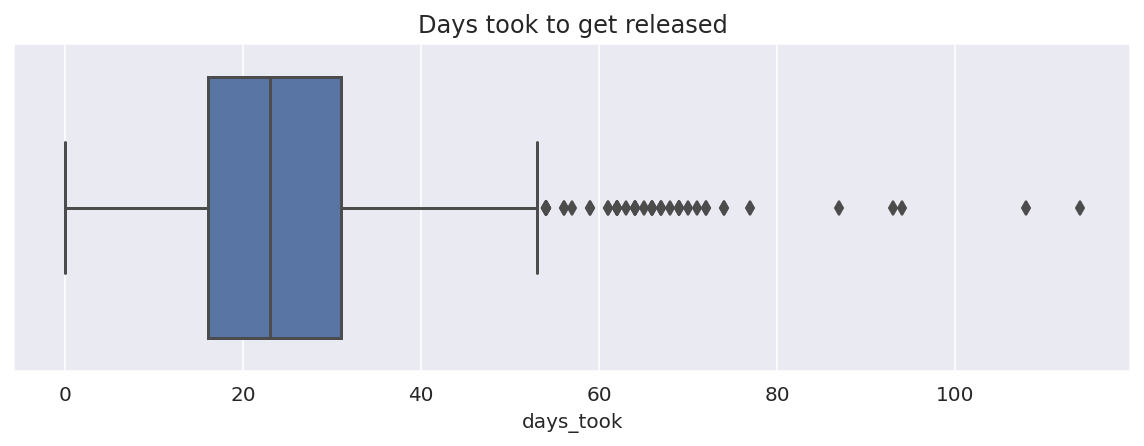

In [55]:
# Days took to release prior positive patients (Exclude NaN values)
patientinfo_release = pd.DataFrame()
patientinfo_release['c_date'] = pd.to_datetime(patientinfo['confirmed_date'], format='%Y-%m-%d')
patientinfo_release['r_date'] = pd.to_datetime(patientinfo['released_date'], format='%Y-%m-%d')
patientinfo_release['days_took'] = (patientinfo_release['r_date']
                                    - patientinfo_release['c_date']).dt.days.astype('Int64')
patientinfo_release = patientinfo_release.dropna()

plt.figure(figsize=(10, 3))
plt.title('Days took to get released')
sns.boxplot(x=patientinfo_release['days_took'])
# sns.swarmplot(x=patientinfo_release['days_took'], color='.25')
plt.show()

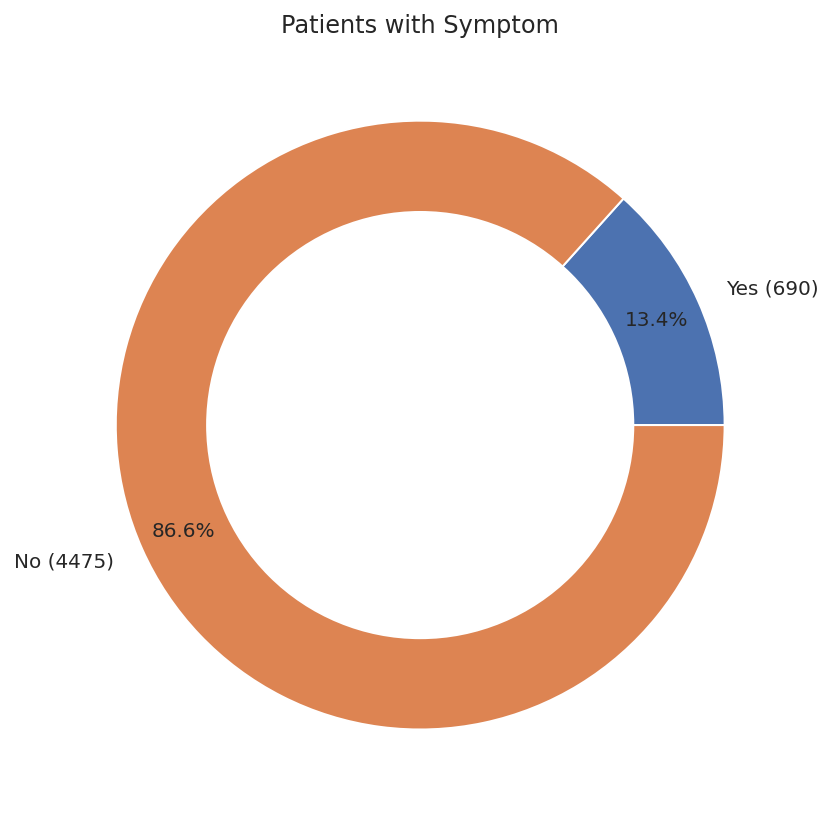

In [56]:
p_nosymp = patientinfo['symptom_onset_date'].isna().sum()

# Proportion of patients with/without symptom
plt.figure(figsize=(7, 7))
plt.title('Patients with Symptom')
plt.pie([p_total - p_nosymp, p_nosymp], labels=[f'Yes ({p_total - p_nosymp})', f'No ({p_nosymp})'], 
        autopct='%.1f%%', pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))
plt.show()

In [58]:
# Importing data: Patient route
patientroute = pd.read_csv('PatientRoute.csv')
patientroute.head()

patient_id  global_num  ...   latitude   longitude
0  1000000001         2.0  ...  37.615246  126.715632
1  1000000001         2.0  ...  37.567241  127.005659
2  1000000002         5.0  ...  37.592560  127.017048
3  1000000002         5.0  ...  37.591810  127.016822
4  1000000002         5.0  ...  37.563992  127.029534

[5 rows x 8 columns]

In [59]:
patientroute_top_log = pd.DataFrame(patientroute['patient_id'].value_counts().head(10))
print('There are {0} patients\' route data.'.format(len(patientroute['patient_id'].unique())))
patientroute_top_place = pd.DataFrame(patientroute['type'].value_counts().head(10))
patientroute_top_place.reset_index(level=0, inplace=True)
patientroute_top_place.columns = ['type', 'count']
patientroute_top_place

There are 939 patients' route data.


type  count
0                    etc   1698
1               hospital   1496
2                  store    507
3             restaurant    451
4  public_transportation    382
5               pharmacy    200
6                airport    120
7                 church    120
8                   cafe     85
9                 school     49

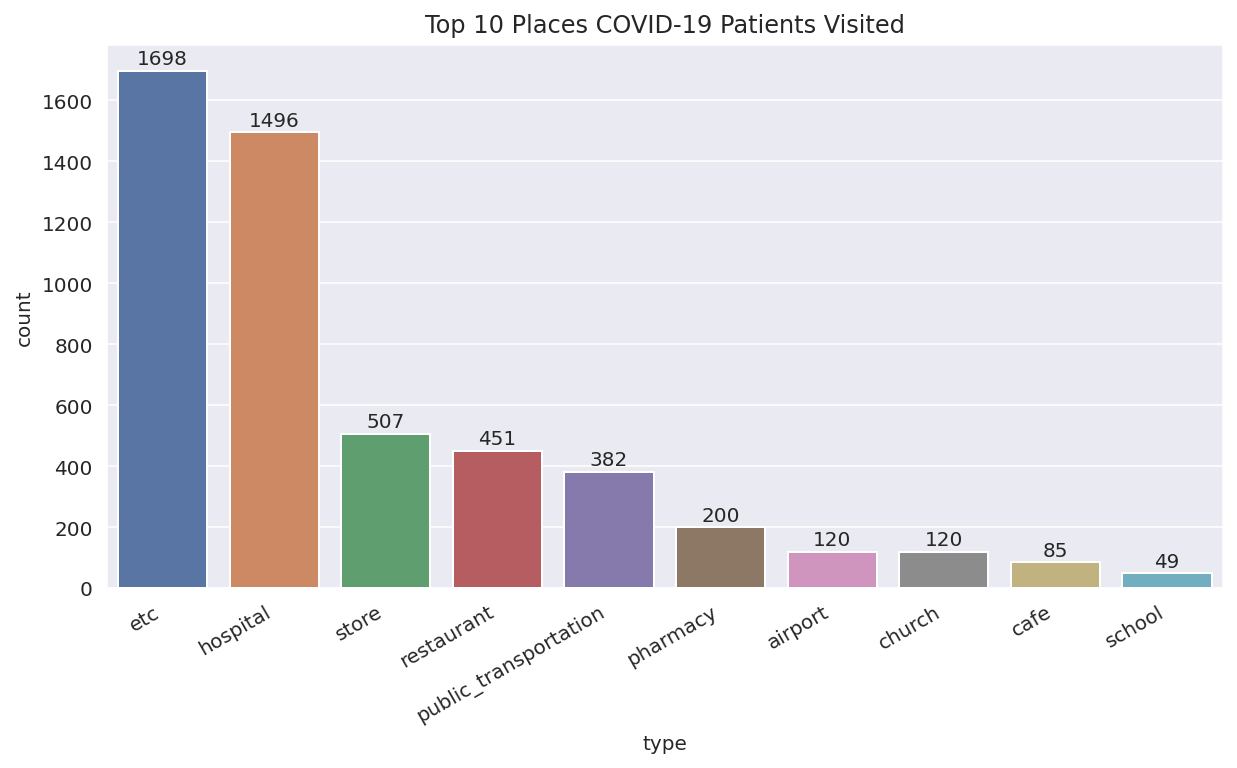

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.title.set_text('Top 10 Places COVID-19 Patients Visited')
sns.barplot(data=patientroute_top_place, x='type', y='count', ax=ax1)
show_values_on_bars(ax1, 'v', modv=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')
plt.show()

In [61]:
# Route of top 10 patients who spread COVID-19
patient_routes = []

for i in range(len(transmit_order)):
    a = []
    tmp_route = patientroute.loc[patientroute['patient_id'] == 
                                 transmit_order[i]].reset_index(drop=True)
    for j in range(len(tmp_route)):
        a.append(tuple([tmp_route.loc[j].latitude, tmp_route.loc[j].longitude]))
    patient_routes.append(a)

print('Saved in \'patient_routes\'')

Saved in 'patient_routes'
